In [1]:
import os
import glob
import gzip
import numpy as np
import pandas as pd
import pickle, sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import PandasTools
#from rdkit.ML.Cluster import Butina
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
import sklearn.feature_extraction
from sklearn.feature_selection import VarianceThreshold
import threading
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pubchempy as pcp
from boruta import boruta_py
from mordred import Calculator, descriptors

In [2]:
%run /Users/vxjdk@leo-pharma.com/mol_utils

# VARIABLES

In [4]:
datasets = ["Homopiperazines","Piperazines","Piperidines","Sulphamides"]
names = ["JAK1 EC50 nM 1027","JAK2 EC50 nM 1024","JAK3 EC50 nM 1026"]
names = names + ['TYK2 EC50 nM 1025']
files = ["/dbfs/FileStore/tables/Homopiperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperidines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Sulphamides_cleaned_Feb_2019.sdf",
        ]
PARENT_DIR = '/dbfs/FileStore/tables'
PICKLES_DIR = '/dbfs/FileStore/pickles'
MOSES_DIR = '/dbfs/FileStore/moses'
CHEMPROP_DIR = '/dbfs/FileStore/chemprop'

ZINC_DIR = '/dbfs/FileStore/ZINC'
ZINC_Models = os.path.join(ZINC_DIR,'models')
VIRTUAL_SCREENING = os.path.join(ZINC_DIR,'virtual_screening')

# FUNCTIONS

In [6]:
def plot_transformation_2D(coords, coloring=None, figure=None, scale=None, color_correction=None):
    if figure:
        fig, ax = figure
    else:
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal',adjustable='box')

    if coloring:
        cmap = plt.get_cmap('jet')
        if scale == 'log':
            coloring = np.log10(np.array(coloring).astype(float))
        if scale == 'p':
            coloring = -np.log10(np.array(coloring).astype(float)*1e-9)
        coloring = np.around(np.array(coloring).astype(float), decimals = 1)
        #ax.scatter(coords[trainsize:, 0], coords[trainsize:, 1], marker = '.', c=gensize#,cmap=colors.Colormap('jet'))
        if scale == 'binary':
            cmap=plt.get_cmap('bwr')
        if color_correction:
            norm = colors.Normalize(vmin=color_correction[0],vmax=color_correction[1])
        sc = ax.scatter(coords[:, 0], 
                        coords[:, 1], 
                        marker = '.', 
                        c=coloring, 
                        cmap=cmap, 
                        norm=norm#, s=len(gensize)**2
                  )
        return fig, ax, sc
    else:
        ax.scatter(coords[:, 0], 
                   coords[:, 1], 
                   marker = '.', 
                   c='k'
                )
        #plt.colorbar(sc)
        return fig, ax

# Exploration

In [8]:
frames = []
for j, file in enumerate(files):
  frames.append(PandasTools.LoadSDF(file,
                              smilesName='SMILES',molColName='Molecule', includeFingerprints=False)) 
all = pd.concat(frames)

/local_disk0/tmp/1567067010462-0/PythonShell.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

 import linecache

In [9]:
from rdkit.Chem import Descriptors, Lipinski
from mordred import SLogP, Calculator

mols = [Chem.MolFromSmiles(smi) for smi in all['Canonical Smiles']]
rb = [Descriptors.NumRotatableBonds(mol) for mol in mols]
hbd = [Lipinski.NumHDonors(mol) for mol in mols]
hba = [Lipinski.NumHAcceptors(mol) for mol in mols]
psa = [Descriptors.TPSA(mol) for mol in mols]

calc1 = Calculator()
calc1.register(SLogP)
slogp = calc1.pandas(mols,nproc=1)

0%| | 0/2188 [00:00<?, ?it/s] 3%|▎ | 73/2188 [00:00<00:02, 724.56it/s] 7%|▋ | 150/2188 [00:00<00:02, 736.58it/s] 10%|█ | 228/2188 [00:00<00:02, 747.78it/s] 14%|█▎ | 300/2188 [00:00<00:02, 738.35it/s] 17%|█▋ | 375/2188 [00:00<00:02, 741.78it/s] 20%|██ | 448/2188 [00:00<00:02, 737.42it/s] 23%|██▎ | 514/2188 [00:00<00:02, 687.21it/s] 27%|██▋ | 586/2188 [00:00<00:02, 696.53it/s] 30%|██▉ | 656/2188 [00:00<00:02, 695.83it/s] 34%|███▎ | 733/2188 [00:01<00:02, 715.43it/s] 37%|███▋ | 814/2188 [00:01<00:01, 739.22it/s] 41%|████ | 887/2188 [00:01<00:01, 716.89it/s] 44%|████▍ | 960/2188 [00:01<00:01, 718.78it/s] 47%|████▋ | 1033/2188 [00:01<00:01, 720.69it/s] 51%|█████ | 1105/2188 [00:01<00:01, 708.08it/s] 54%|█████▍ | 1181/2188 [00:01<00:01, 722.00it/s] 57%|█████▋ | 1257/2188 [00:01<00:01, 730.37it/s] 61%|██████ | 1331/2188 [00:01<00:01, 719.39it/s] 64%|██████▍ | 1403/2188 [00:01<00:01, 631.01it/s] 67%|██████▋ | 1471/2188 [00:02<00:01, 643.77it/s] 70%|███████ | 1542/2188 [00:02<00:00, 661.77it/s] 74%|███████▍ | 1619/2188 [00:02<00:00, 689.06it/s] 77%|███████▋ | 1692/2188 [00:02<00:00, 700.80it/s] 81%|████████ | 1763/2188 [00:02<00:00, 702.89it/s] 84%|████████▍ | 1834/2188 [00:02<00:00, 683.34it/s] 87%|████████▋ | 1903/2188 [00:02<00:00, 610.32it/s] 90%|████████▉ | 1966/2188 [00:02<00:00, 611.34it/s] 93%|█████████▎| 2035/2188 [00:02<00:00, 632.02it/s] 96%|█████████▋| 2107/2188 [00:03<00:00, 654.79it/s]100%|█████████▉| 2178/2188 [00:03<00:00, 668.51it/s]100%|██████████| 2188/2188 [00:03<00:00, 692.25it/s]

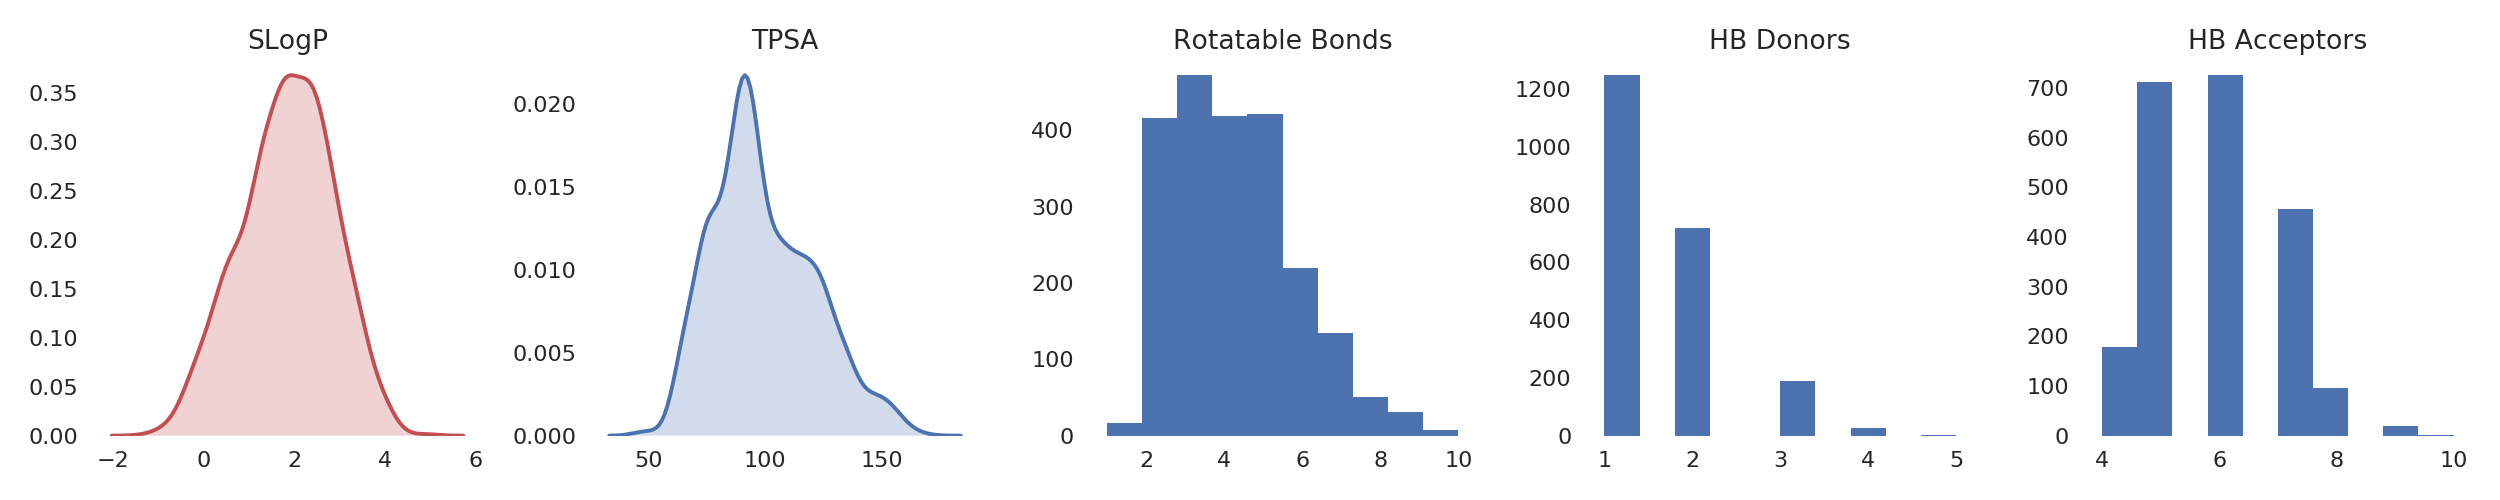

In [10]:
import seaborn as sns; sns.set(color_codes=True)
plt.close()
sns.set_context("poster")
plt.close()
fig = plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
ax = sns.kdeplot(slogp['SLogP'].tolist(), shade=True, color="r")
ax.set_title('SLogP')
ax.grid(False)
plt.subplot(1,5,2)
ax = sns.kdeplot(psa, shade=True, color="b")
ax.set_title('TPSA')
ax.grid(False)
plt.subplot(1,5,3)
plt.hist(rb)
plt.title('Rotatable Bonds')
plt.subplot(1,5,4)
plt.hist(hbd)
plt.title('HB Donors')
plt.subplot(1,5,5)
plt.hist(hba)
plt.title('HB Acceptors')
plt.tight_layout()
display(plt.show())

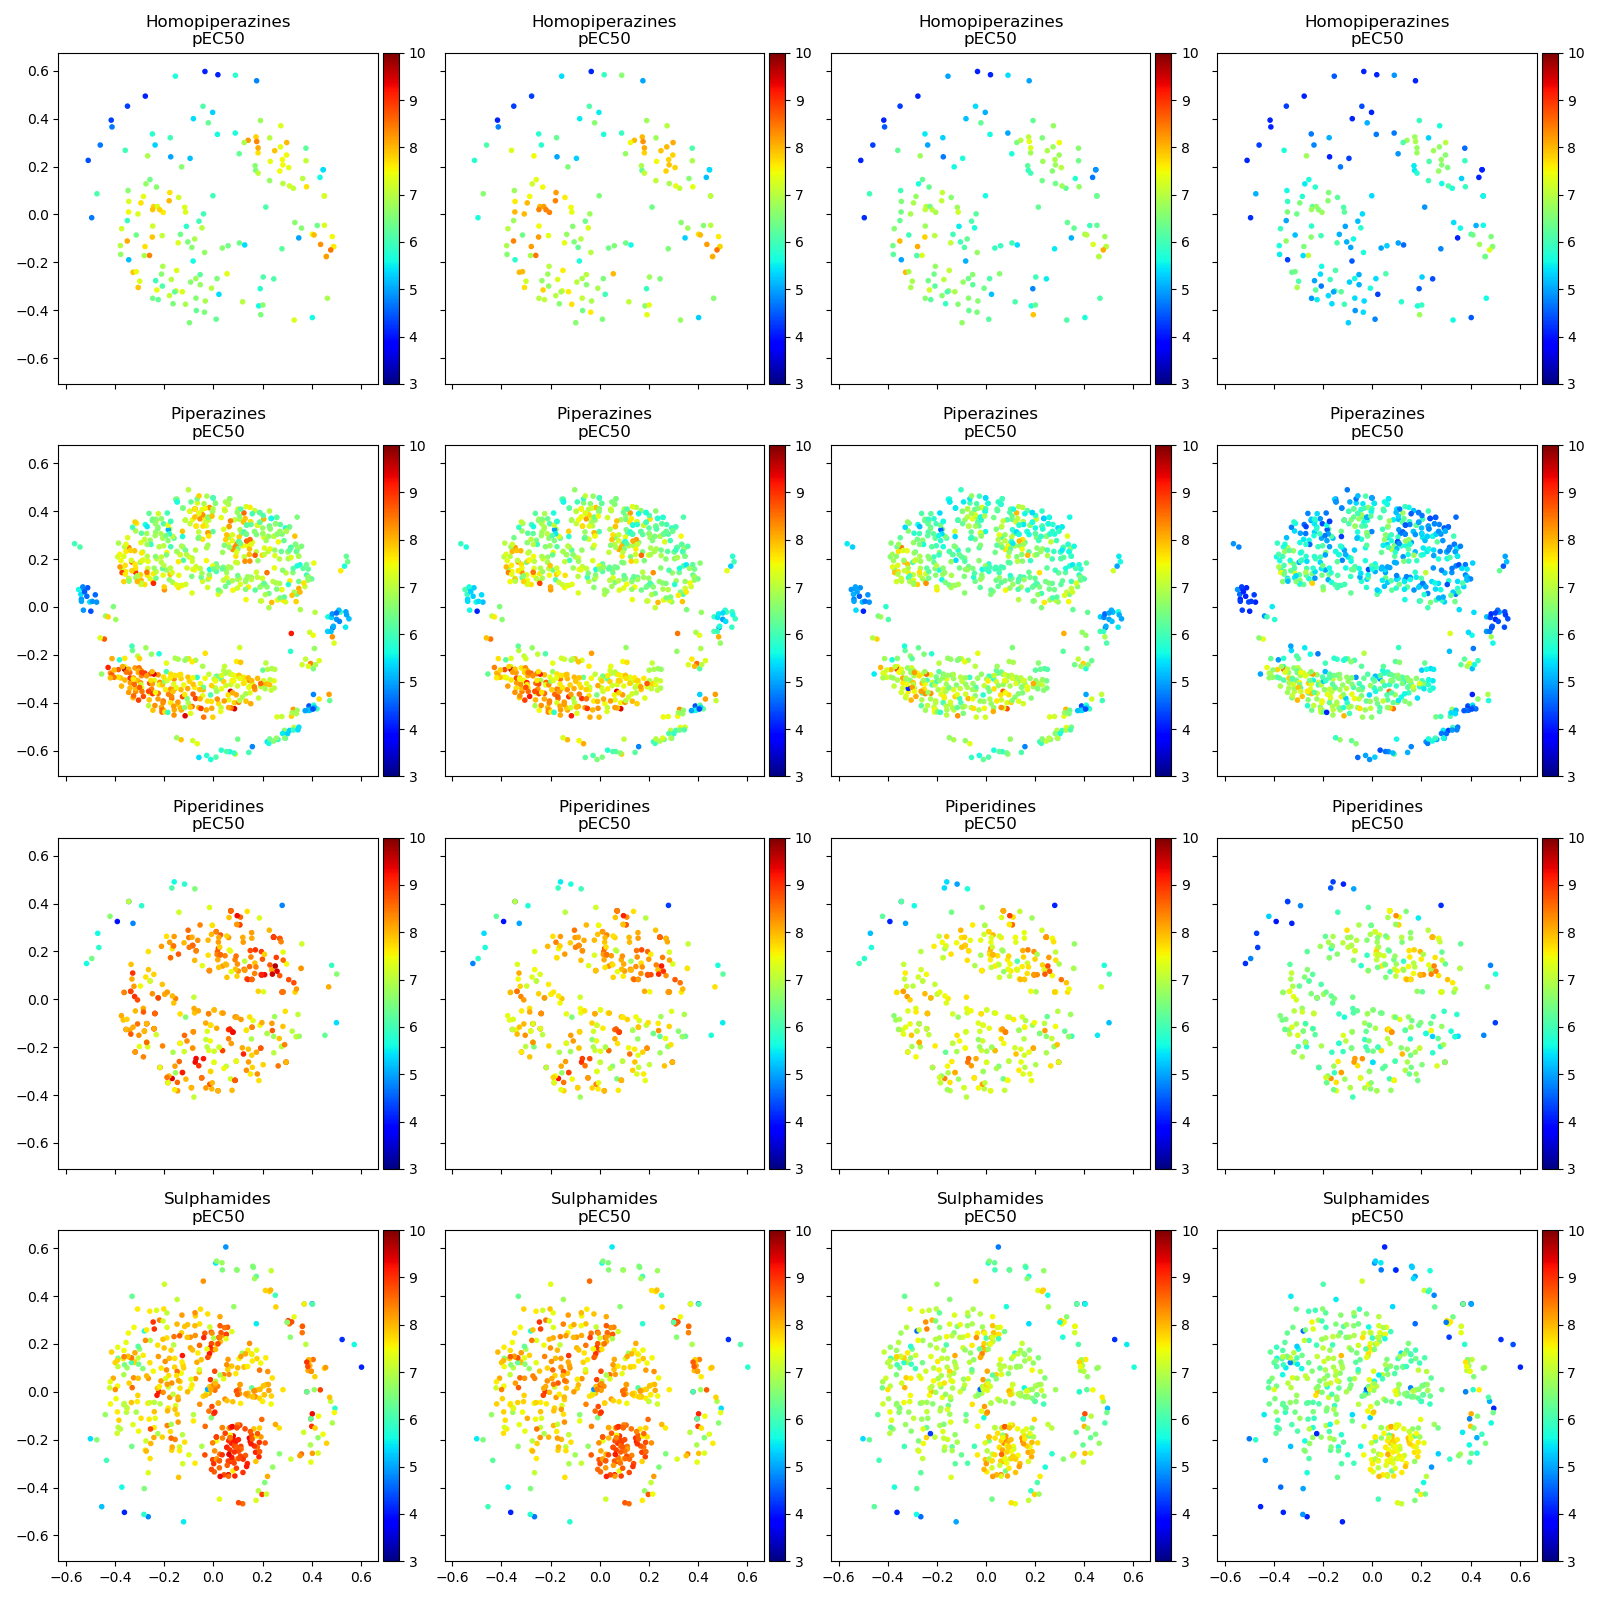

In [11]:
f, axes = plt.subplots(len(files), len(names), sharex = True, sharey=True, figsize=(len(files)*len(names),len(files)**2))
for j, file in enumerate(files):
  frame = PandasTools.LoadSDF(file,
                              smilesName='SMILES',molColName='Molecule', includeFingerprints=False)
  frame.replace('newline',np.nan, inplace=True)
  #drugs = [mol for mol in Chem.SDMolSupplier("Piperazines_cleaned_Feb_2019.sdf") if mol != None]

  frame.dropna(subset=names,inplace=True)
  cols = [frame[name].tolist() for name in names]
  fps = get_fps(frame['Molecule'].tolist(), bit=True)
  dists = fps_distances(fps)
  coords = get_embedding('mds', 2, dists)

#f.figure(figsize = (len(cols)*4,len(cols)))
#plots = (ax1, ax2, ax3)
  for i, col in enumerate(cols):
    #fig = plt.figure(figsize = (len(cols)*4,len(cols)))
    #ax = fig.add_subplot(1,3,i+1)
    #plots[i].set_aspect('equal',adjustable='box')
    f, ax, sc = plot_transformation_2D(coords,
                                     coloring=col,
                                     figure=(f, axes[j][i]),
                                     scale='p', 
                                     color_correction=(3,10))
    ax.set_title(datasets[j]+'\n'+'pEC50')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(sc, cax=cax)
#fig.colorbar(sc)
#f.subplots_adjust(right=0.8)
f.tight_layout()
display(f)

In [12]:
ext_sdf = Chem.ForwardSDMolSupplier(gzip.open('JAK1_20190311_sdf-d4409.gz'))
ext_mols = [x for x in ext_sdf if x is not None]
print(list(ext_mols[0].GetPropNames()))

['PUBCHEM_COMPOUND_CID', 'PUBCHEM_COMPOUND_CANONICALIZED', 'PUBCHEM_CACTVS_COMPLEXITY', 'PUBCHEM_CACTVS_HBOND_ACCEPTOR', 'PUBCHEM_CACTVS_HBOND_DONOR', 'PUBCHEM_CACTVS_ROTATABLE_BOND', 'PUBCHEM_CACTVS_SUBSKEYS', 'PUBCHEM_IUPAC_OPENEYE_NAME', 'PUBCHEM_IUPAC_CAS_NAME', 'PUBCHEM_IUPAC_NAME', 'PUBCHEM_IUPAC_SYSTEMATIC_NAME', 'PUBCHEM_IUPAC_TRADITIONAL_NAME', 'PUBCHEM_IUPAC_INCHI', 'PUBCHEM_IUPAC_INCHIKEY', 'PUBCHEM_XLOGP3_AA', 'PUBCHEM_EXACT_MASS', 'PUBCHEM_MOLECULAR_FORMULA', 'PUBCHEM_MOLECULAR_WEIGHT', 'PUBCHEM_OPENEYE_CAN_SMILES', 'PUBCHEM_OPENEYE_ISO_SMILES', 'PUBCHEM_CACTVS_TPSA', 'PUBCHEM_MONOISOTOPIC_WEIGHT', 'PUBCHEM_TOTAL_CHARGE', 'PUBCHEM_HEAVY_ATOM_COUNT', 'PUBCHEM_ATOM_DEF_STEREO_COUNT', 'PUBCHEM_ATOM_UDEF_STEREO_COUNT', 'PUBCHEM_BOND_DEF_STEREO_COUNT', 'PUBCHEM_BOND_UDEF_STEREO_COUNT', 'PUBCHEM_ISOTOPIC_ATOM_COUNT', 'PUBCHEM_COMPONENT_COUNT', 'PUBCHEM_CACTVS_TAUTO_COUNT', 'PUBCHEM_COORDINATE_TYPE', 'PUBCHEM_BONDANNOTATIONS']

In [13]:
frame = external_prep('/'.join([PARENT_DIR, 'JAK2_20190311.csv']), 
                      '/'.join([PARENT_DIR, 'JAK2_20190311_sdf-3d49e.gz']))
frame.drop_duplicates(subset='cid', inplace=True)
frame.dropna(subset=['acvalue'],inplace=True)
#cols = [val*1e3 for val in frame['acvalue']]
fps = get_fps(frame['Molecule'].tolist(), bit=True)
clusters=ClusterFps(fps, cutoff=0.1)
print(len(clusters))

5309

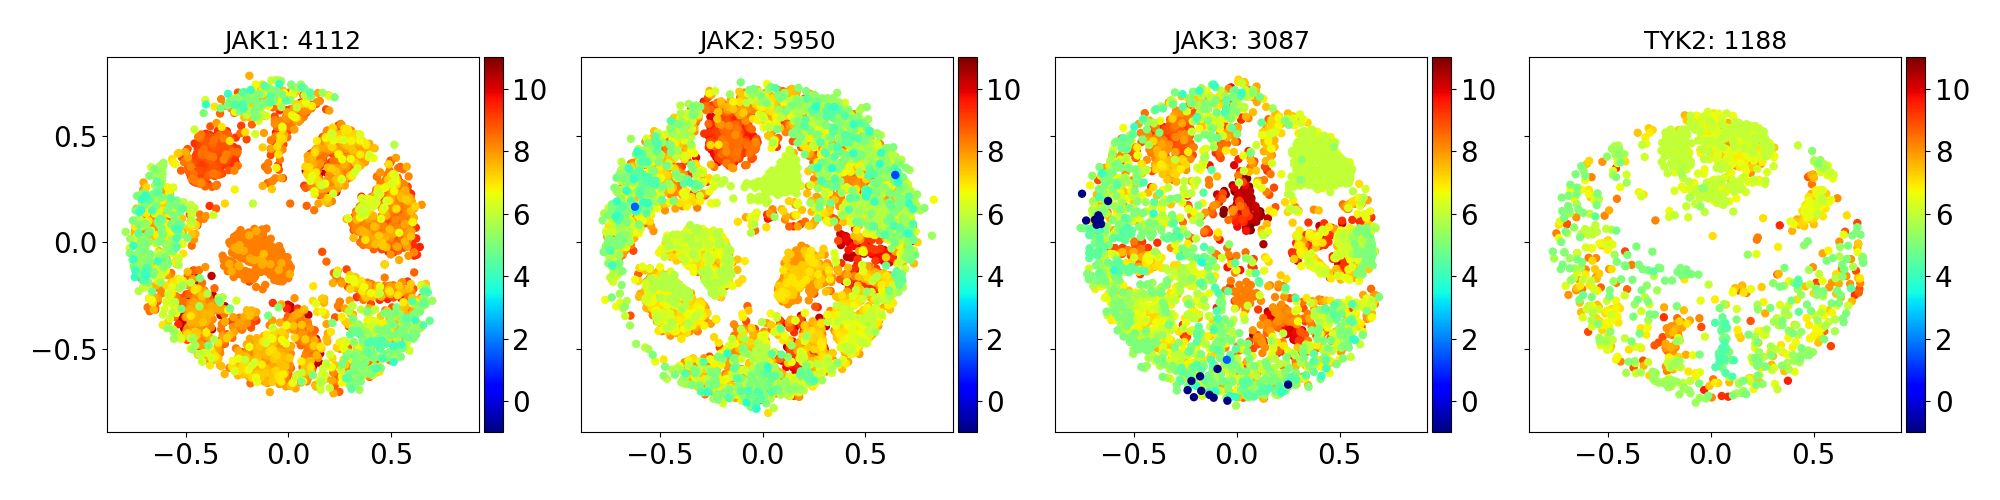

In [14]:
csvs = ['JAK1_20190311.csv', 
        'JAK2_20190311.csv', 
        'JAK3_20190311.csv', 
        'TYK2_20190311.csv']
sdfs = ['JAK1_20190311_sdf-d4409.gz', 
        'JAK2_20190311_sdf-3d49e.gz', 
        'JAK3_20190311_sdf-08df5.gz', 
        'TYK2_20190311_sdf-6ca3e.gz']
plt.close()
#import importlib
import matplotlib
#importlib.reload(matplotlib); importlib.reload(plt); importlib.reload(sns)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

f, axes = plt.subplots(1, 4, sharex = True, sharey=True, figsize=(20,5))
for j, file in enumerate(csvs):
  frame = external_prep('/'.join([PARENT_DIR, file]), 
                        '/'.join([PARENT_DIR, sdfs[j]]))
  frame.drop_duplicates(subset='cid', inplace=True)
  frame.dropna(subset=['acvalue'],inplace=True)
  cols = [val*1e3 for val in frame['acvalue']]

  coords = pickle.load(open(os.path.join(PICKLES_DIR,'dists_'+file[:-4]+'.p'),'rb'))
  f, ax, sc = plot_transformation_2D(coords,
                                   coloring=cols,
                                   figure=(f, axes[j]),
                                   scale='p', 
                                   color_correction=(-1,11))
  ax.set_title(str(file[:4])+': '+str(len(frame)), fontsize=18)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

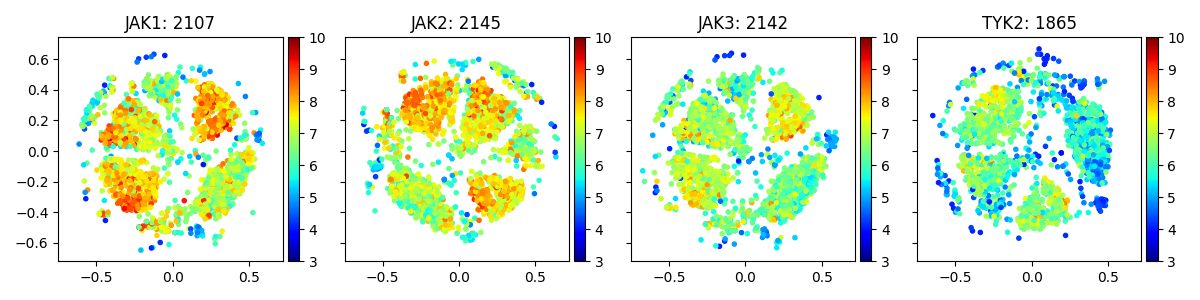

In [15]:
f, axes = plt.subplots(1, 4, sharex = True, sharey=True, figsize=(20,5))
frames = []
for j, file in enumerate(files):
  frame = PandasTools.LoadSDF(file,
                              smilesName='SMILES',molColName='Molecule', includeFingerprints=False)
  frame.replace('newline',np.nan, inplace=True)
  #drugs = [mol for mol in Chem.SDMolSupplier("Piperazines_cleaned_Feb_2019.sdf") if mol != None]

  #frame.dropna(subset=names,inplace=True)
  frames.append(frame)
frame = pd.concat(frames,ignore_index=True)

for i, name in enumerate(names):
  pl_frame = frame.dropna(subset=[name])
  col = pl_frame[name].tolist()
  fps = get_fps(pl_frame['Molecule'].tolist(), bit=True)
  dists = fps_distances(fps)
  coords = get_embedding('mds', 2, dists)
  f, ax, sc = plot_transformation_2D(coords,
                                   coloring=col,
                                   figure=(f, axes[i]),
                                   scale='p', 
                                   color_correction=(0,10))
  ax.set_title(str(names[i][:4])+': '+str(len(pl_frame)))
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

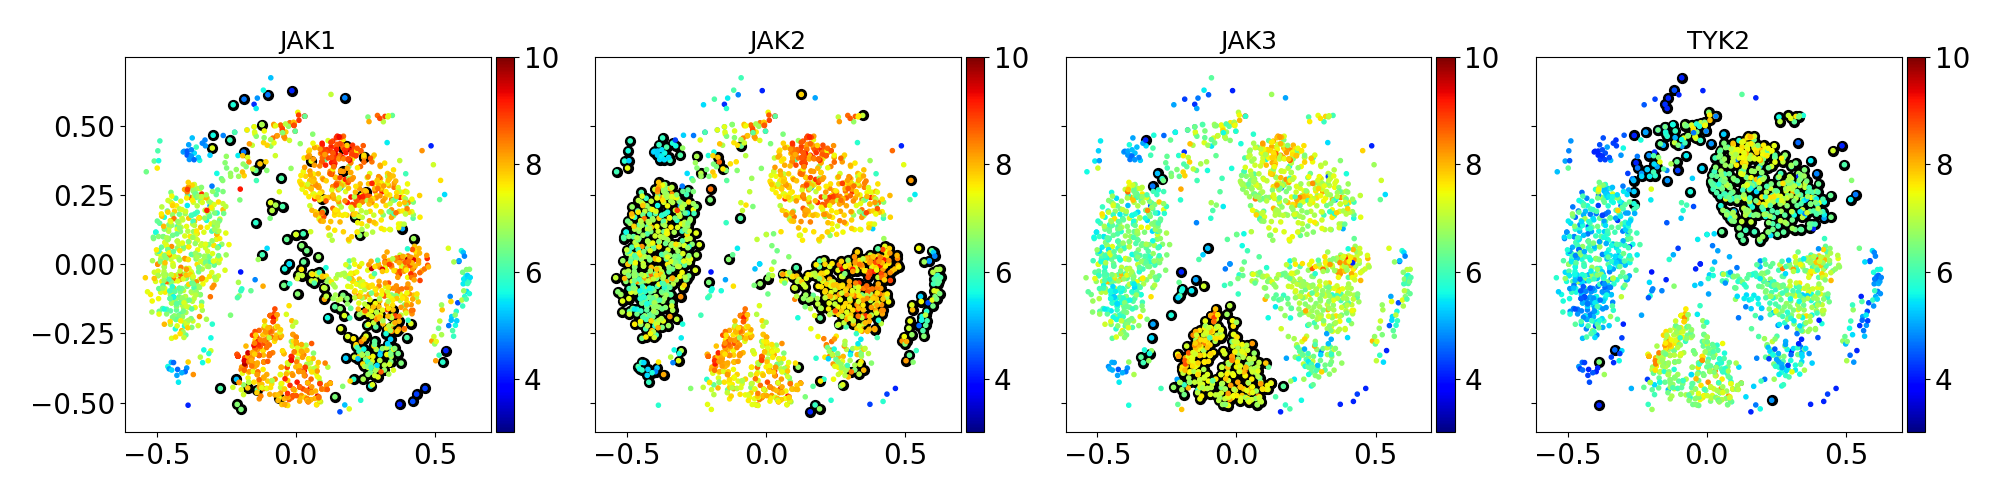

In [16]:
f, axes = plt.subplots(1, 4, sharex = True, sharey=True, figsize=(20,5))
from_grey = 0
until_grey = 0
for i, col in enumerate(cols):
  
  until_grey += len(frames[i])
  axes[i].scatter(coords[from_grey:until_grey,0],coords[from_grey:until_grey,1],c='k',marker='.',s=200)
  f, ax, sc = plot_transformation_2D(coords,
                                   coloring=col,
                                   figure=(f, axes[i]),
                                   scale='p', 
                                   color_correction=(3,10))
  
  ax.set_title(str(names[i][:4]), fontsize=18)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  f.colorbar(sc, cax=cax)
  from_grey += len(frames[i])
f.tight_layout()
display(f)

In [17]:
csvs = ['JAK1_20190311.csv', 
        'JAK2_20190311.csv', 
        'JAK3_20190311.csv', 
        'TYK2_20190311.csv']
sdfs = ['JAK1_20190311_sdf-d4409.gz', 
        'JAK2_20190311_sdf-3d49e.gz', 
        'JAK3_20190311_sdf-08df5.gz', 
        'TYK2_20190311_sdf-6ca3e.gz']
frames = []
for j, file in enumerate(csvs):
  frame = pd.read_csv(os.path.join(PARENT_DIR,file))
  print(frame.shape)
  frame.drop_duplicates(subset='cid', inplace=True)
  print(frame.shape)
  frame.dropna(subset=['acvalue'],inplace=True)
  print(frame.shape)
  frames.append(frame)

(5982, 7)
(4838, 7)
(4112, 7)
(228472, 7)
(225538, 7)
(5950, 7)
(5855, 7)
(4831, 7)
(3087, 7)
(3018, 7)
(2271, 7)
(1188, 7)

In [18]:
df = frames[0].filter(['cid','activity','acvalue'])
df.columns = list(df.columns[:2])+['JAK1']

cols = ['JAK2','JAK3','TYK2']
for i,frame in enumerate(frames[1:]):
  df = df.merge(frame.filter(['cid','activity','acvalue']).rename(columns={'activity':'activity_'+cols[i],'acvalue':cols[i]}),on='cid')
print(df.shape)

(1015, 9)

In [19]:
cols = ['JAK1','JAK2','JAK3','TYK2']
for col in cols:
  df[col]= [-np.log10(val*1e-6) for val in df[col]]

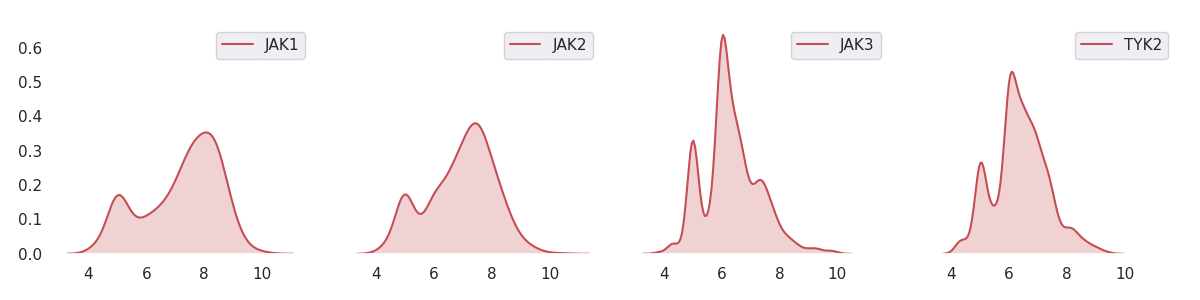

In [20]:
import seaborn as sns; sns.set(color_codes=True)
plt.close()
f, axes = plt.subplots(1, 4, sharex = True, sharey=True, figsize=(12,3))
for i,col in enumerate(cols):

  sns.kdeplot(df[col], shade=True, color='r',ax=axes[i])
plt.tight_layout()
display(plt.show())

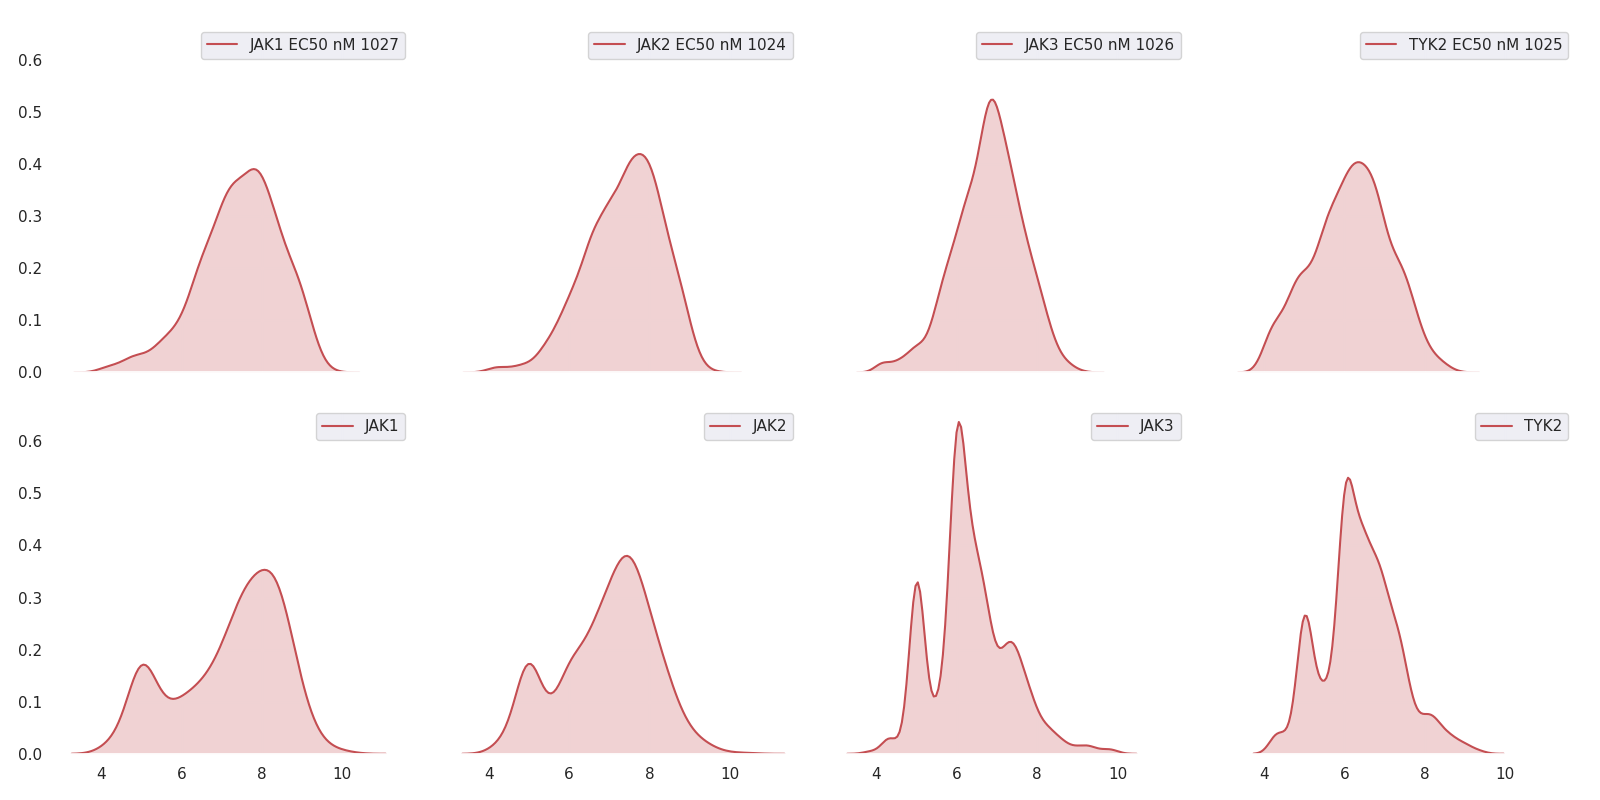

In [21]:
import seaborn as sns; sns.set(color_codes=True)
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv'))
plt.close()
f, axes = plt.subplots(2, 4, sharex = True, sharey=True, figsize=(16,8))
#plt.scatter(test[names[0]],diff_cp[diff_cp.columns[0]])
for i in range(4):
  for j in range(2):
    if j==0:
      #sns.kdeplot(test[names[i]], diff_cp[diff_cp.columns[i]], n_levels=10, cmap="Purples_d",ax=axes[j][i],clip=((0,10),(0,1)))
      sns.kdeplot(test[names[i]], shade=True, color='r',ax=axes[j][i])
    if j==1:
      sns.kdeplot(df[cols[i]], shade=True, color='r',ax=axes[j][i])
plt.tight_layout()
display(plt.show())

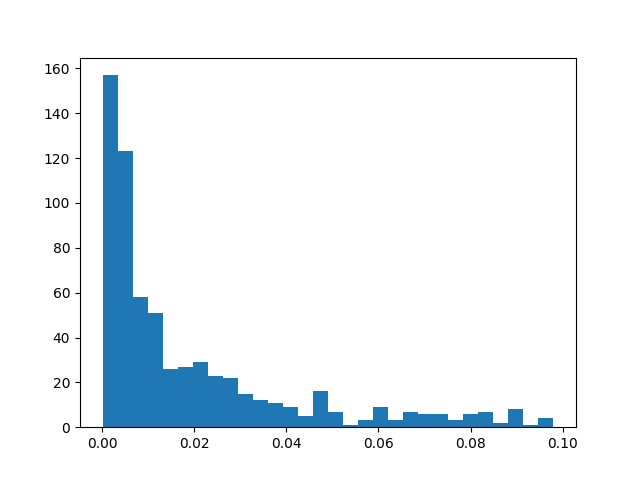

In [22]:
plt.close()
plt.hist([val for val in df.JAK1 if val < 0.1],bins=30)
display(plt.show())

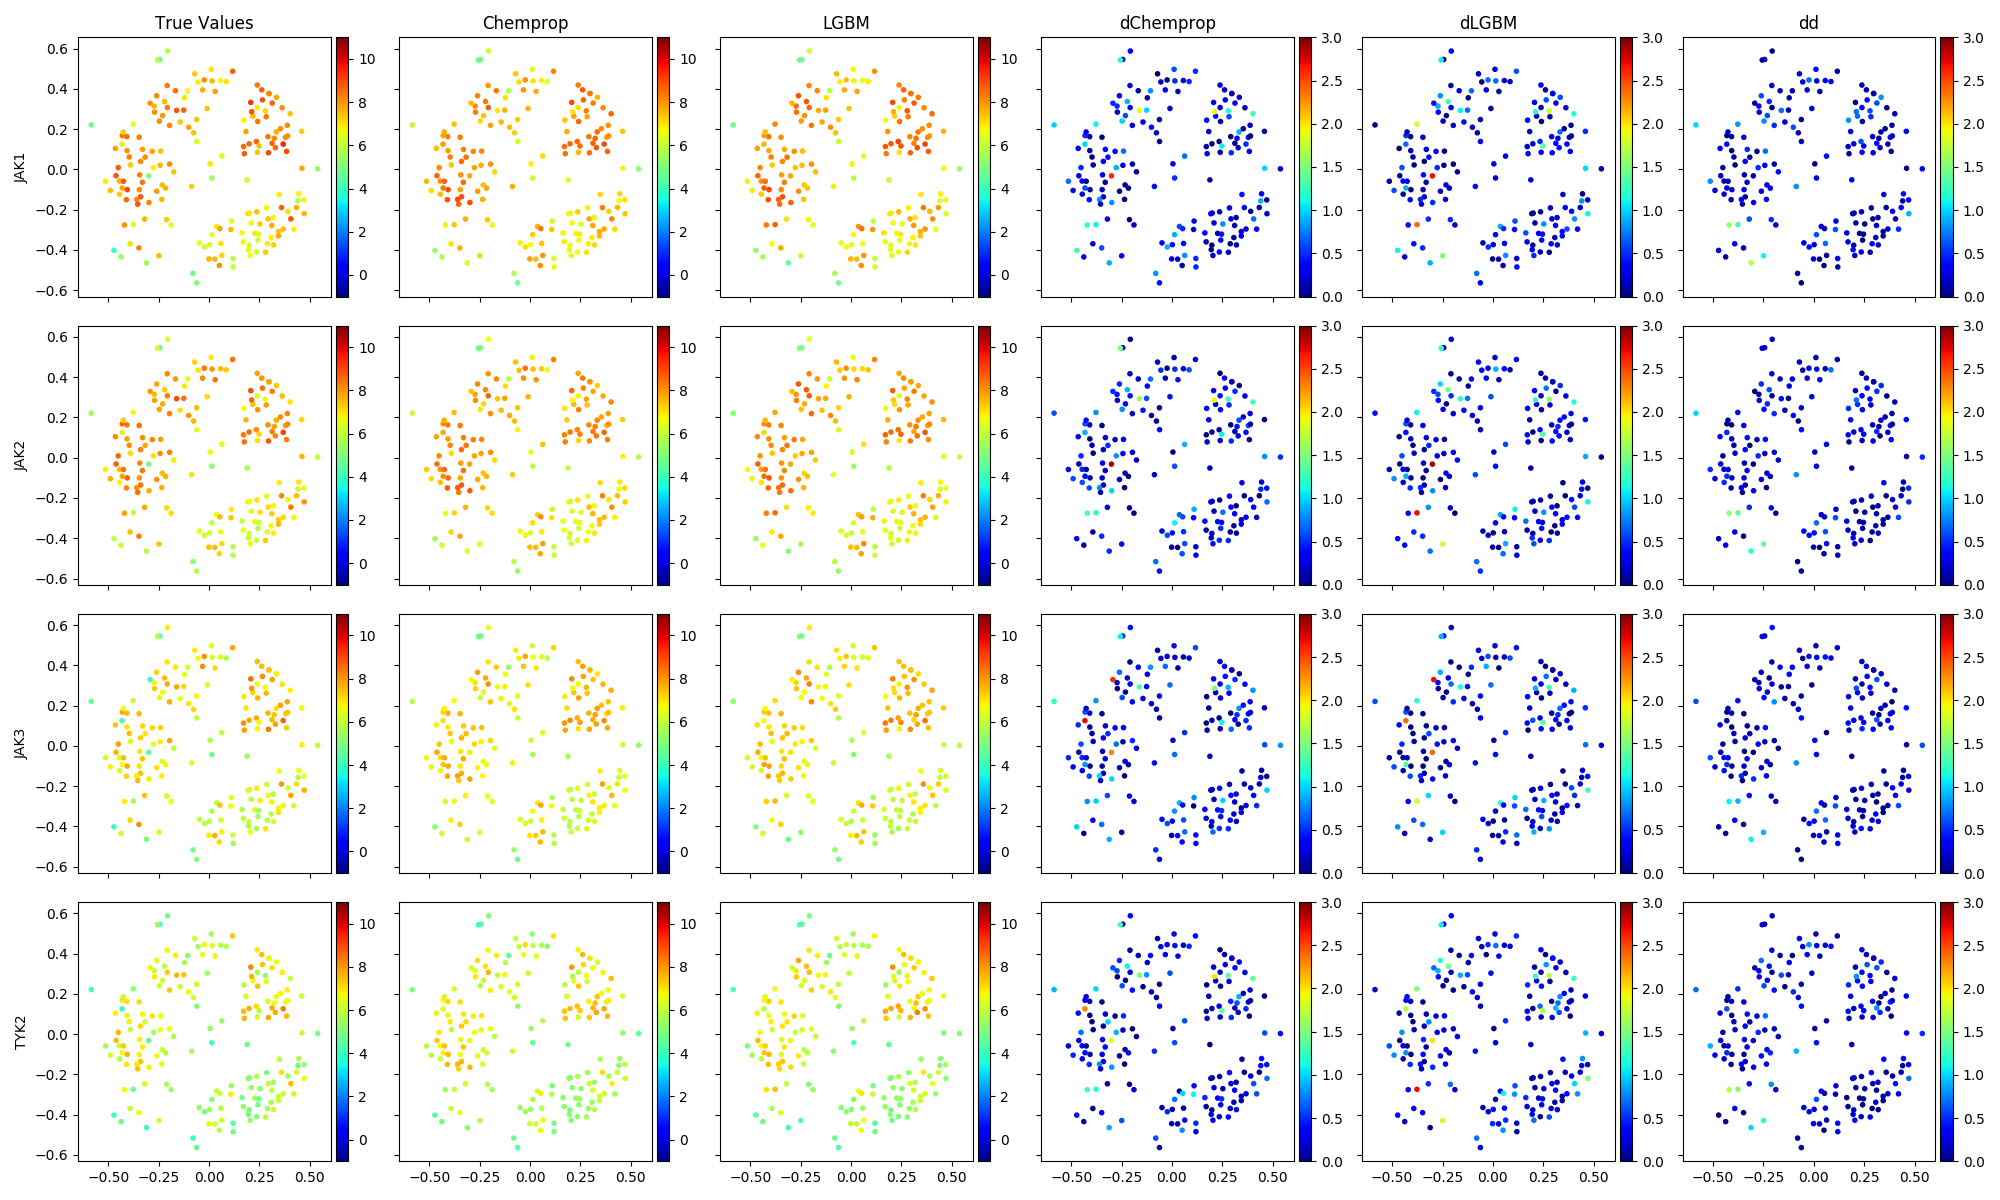

In [23]:
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'))
chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x','fold_0/model_0/test_preds.csv'))
XGB_DIR = '/dbfs/FileStore/XGB-Hopt/'
#lgb_preds = pd.read_csv(os.path.join(XGB_DIR,'predicts20190429.csv'))
lgb_preds = pd.read_csv(os.path.join(XGB_DIR,'predicts20190514-Test.csv'))
diff_cp = test.filter(names).subtract(chemprop_preds.filter(names)).abs()
diff_lgb = test.filter(names).subtract(lgb_preds.filter(names)).abs()
cp_lgb = chemprop_preds.filter(names).subtract(lgb_preds.filter(names)).abs()
dfs = [test.filter(names),chemprop_preds.filter(names),lgb_preds.filter(names),diff_cp,diff_lgb,cp_lgb]
corrections = [(-1,11),(-1,11),(-1,11),(0,3),(0,3),(0,3)]
titles = ['True Values','Chemprop','LGBM','dChemprop','dLGBM','dd']
f, axes = plt.subplots(4, 6, sharex = True, sharey=True, figsize=(20,12))
fps = get_fps([Chem.MolFromSmiles(smi) for smi in test['smiles']], bit=True)
dists = fps_distances(fps)
coords = get_embedding('mds', 2, dists)
for j, name in enumerate(names):
  for i, df in enumerate(dfs):
    
    f, ax, sc = plot_transformation_2D(coords,
                                     coloring=dfs[i][name].tolist(),
                                     figure=(f, axes[j][i]),
                                     #scale='p', 
                                     color_correction=corrections[i])
    #ax.set_title(str(file[:4])+': '+str(len(frame)))
    if i==0:
      ax.set_ylabel(names[j][:4])
    if j==0:
      ax.set_title(titles[i])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_aspect('equal',adjustable='box')
    f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

# binary comparison

In [25]:
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183_binary.csv'))
chemprop_preds = pd.read_csv(os.path.join(os.path.join(CHEMPROP_DIR,'JAK','binary-4x','model','fold_0/model_0/test_preds.csv')))
XGB_DIR = '/dbfs/FileStore/XGB-Hopt/'
lgb_preds = pd.read_csv(os.path.join(XGB_DIR,'predicts20190501_binary.csv'))
diff_cp = test.filter(names).round(0).subtract(chemprop_preds.filter(names).round(0)).abs()
diff_lgb = test.filter(names).round(0).subtract(lgb_preds.filter(names).round(0)).abs()
cp_lgb = diff_cp.filter(names).subtract(diff_lgb.filter(names)).abs()
dfs = [test.filter(names),chemprop_preds.filter(names),lgb_preds.filter(names),diff_cp,diff_lgb,cp_lgb]
fps = get_fps([Chem.MolFromSmiles(smi) for smi in test['smiles']], bit=True)
dists = fps_distances(fps)
coords = get_embedding('mds', 2, dists)


Errors in conversion: 0
Selected transformation: MDS

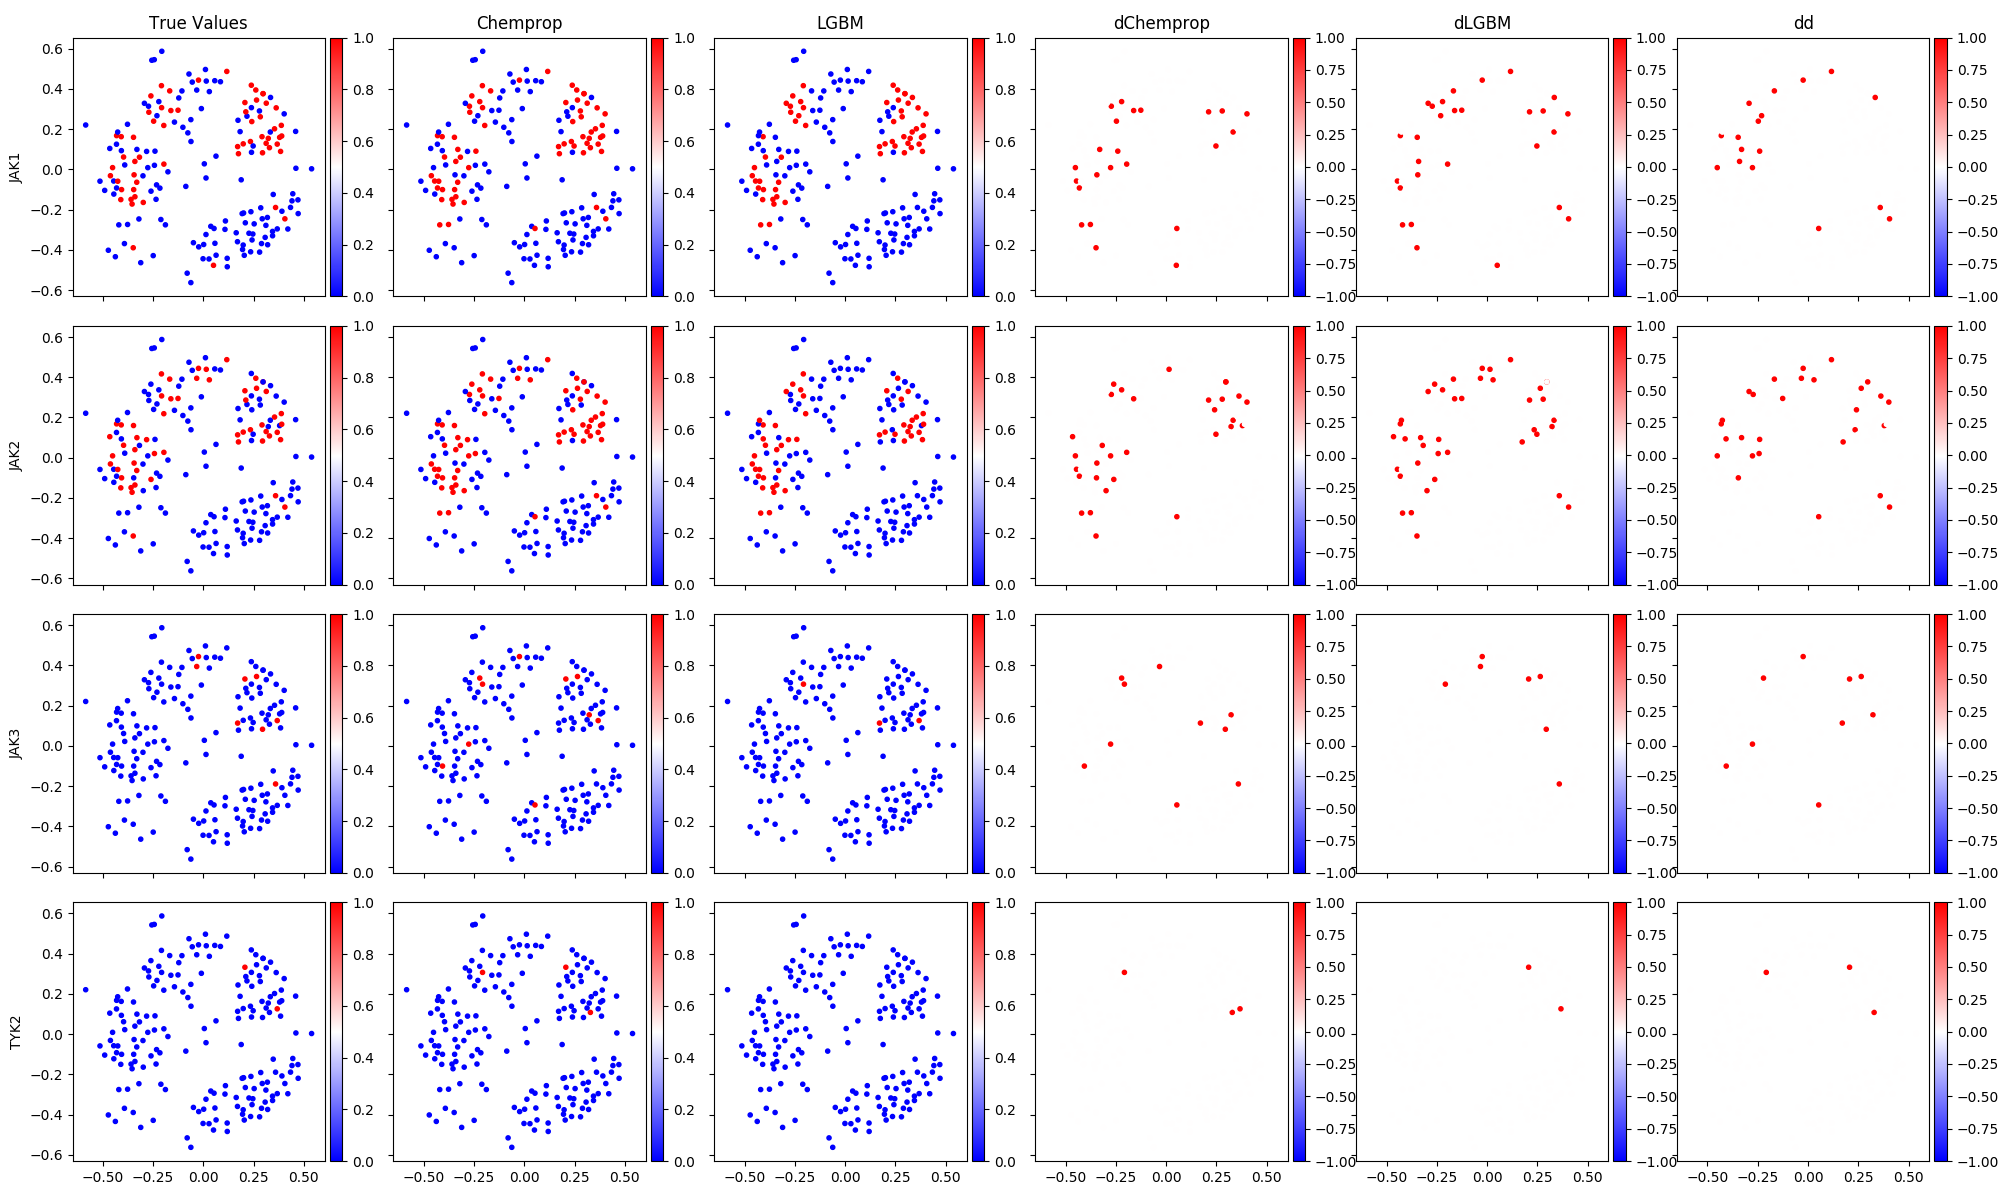

In [26]:
f, axes = plt.subplots(4, 6, sharex = True, sharey=True, figsize=(20,12))
corrections = [(0,1),(0,1),(0,1),(-1,1),(-1,1),(-1,1)]
titles = ['True Values','Chemprop','LGBM','dChemprop','dLGBM','dd']
for j, name in enumerate(names):
  for i, df in enumerate(dfs):
    #if halves[i]:
      
    f, ax, sc = plot_transformation_2D(coords,
                                       coloring=np.round(dfs[i][name]).tolist(),
                                       figure=(f, axes[j][i]),
                                       scale='binary', 
                                       color_correction=corrections[i])
    if i==0:
      ax.set_ylabel(names[j][:4])
    if j==0:
      ax.set_title(titles[i])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_aspect('equal',adjustable='box')
    f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

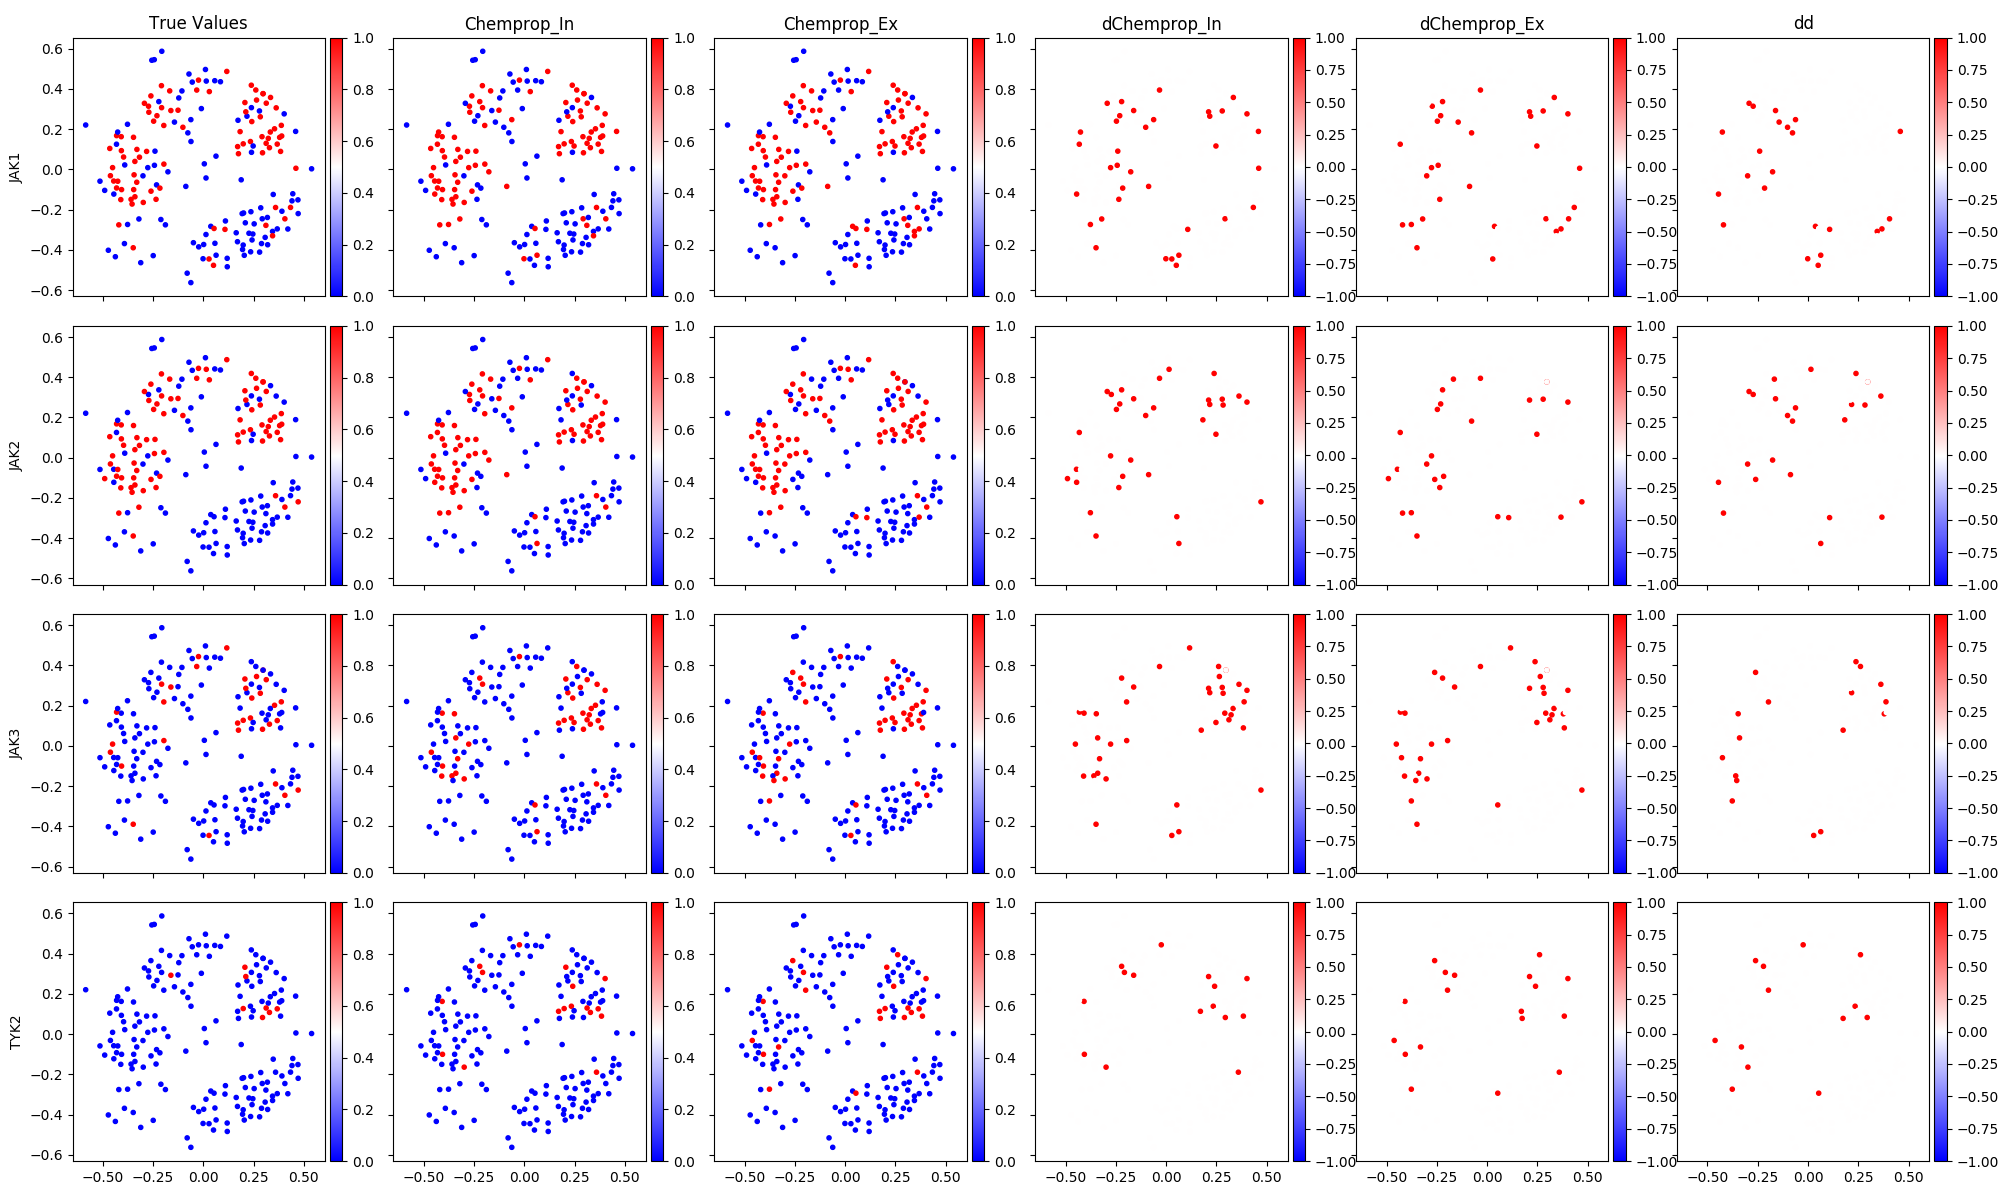

In [27]:
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'))
chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int','fold_0/model_0/test_preds_bin76_int.csv'))
ch_ext_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/test_preds_bin76_ext.csv'))
names = ['JAK1','JAK2','JAK3','TYK2']
diff_cp = test.filter(names).round(0).subtract(chemprop_preds.filter(names).round(0)).abs()
diff_ext = test.filter(names).round(0).subtract(ch_ext_preds.filter(names).round(0)).abs()
cp_ext = diff_cp.filter(names).subtract(diff_ext.filter(names)).abs()
dfs = [test.filter(names),chemprop_preds.filter(names),ch_ext_preds.filter(names),diff_cp,diff_ext,cp_ext]
fps = get_fps([Chem.MolFromSmiles(smi) for smi in test['smiles']], bit=True)
dists = fps_distances(fps)
coords = get_embedding('mds', 2, dists)

f, axes = plt.subplots(4, 6, sharex = True, sharey=True, figsize=(20,12))
corrections = [(0,1),(0,1),(0,1),(-1,1),(-1,1),(-1,1)]
titles = ['True Values','Chemprop_In','Chemprop_Ex','dChemprop_In','dChemprop_Ex','dd']
for j, name in enumerate(names):
  for i, df in enumerate(dfs):
    #if halves[i]:
      
    f, ax, sc = plot_transformation_2D(coords,
                                       coloring=np.round(dfs[i][name]).tolist(),
                                       figure=(f, axes[j][i]),
                                       scale='binary', 
                                       color_correction=corrections[i])
    if i==0:
      ax.set_ylabel(names[j])
    if j==0:
      ax.set_title(titles[i])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_aspect('equal',adjustable='box')
    f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

In [28]:
from sklearn.metrics import roc_auc_score
names = ['JAK1','JAK2','JAK3','TYK2']
chemprop_auc = {}
ch_ext_auc = {}
for name in names:
  chemprop_auc[name]=[roc_auc_score(test[name], chemprop_preds[name])]
  ch_ext_auc[name]=[roc_auc_score(test[name], ch_ext_preds[name])]
display(pd.DataFrame.from_dict(chemprop_auc))

JAK1 JAK2 JAK3 TYK2 0.895828338527931 0.9105582524271846 0.8300910596026491 0.7828571428571428

In [29]:
display(pd.DataFrame.from_dict(ch_ext_auc))

JAK1 JAK2 JAK3 TYK2 0.9156677055861904 0.9182038834951457 0.8820364238410596 0.8407142857142857

In [30]:
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'))
chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int_Feat_SLogP','fold_0/model_0/test_preds_bin76_int_Feat_SLogP.csv'))
ch_ext_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext_Feat_SLogP','fold_0/model_0/test_preds_bin76_ext_Feat_SLogP.csv'))
from sklearn.metrics import roc_auc_score
names = ['JAK1','JAK2','JAK3','TYK2']
chemprop_auc = {}
ch_ext_auc = {}
for name in names:
  chemprop_auc[name]=[roc_auc_score(test[name], chemprop_preds[name])]
  ch_ext_auc[name]=[roc_auc_score(test[name], ch_ext_preds[name])]
display(pd.DataFrame.from_dict(chemprop_auc))

JAK1 JAK2 JAK3 TYK2 0.9062574922081037 0.9137135922330096 0.847682119205298 0.8057142857142858

In [31]:
display(pd.DataFrame.from_dict(ch_ext_auc))

JAK1 JAK2 JAK3 TYK2 0.9064972428674178 0.9288834951456311 0.8512003311258277 0.8007142857142857

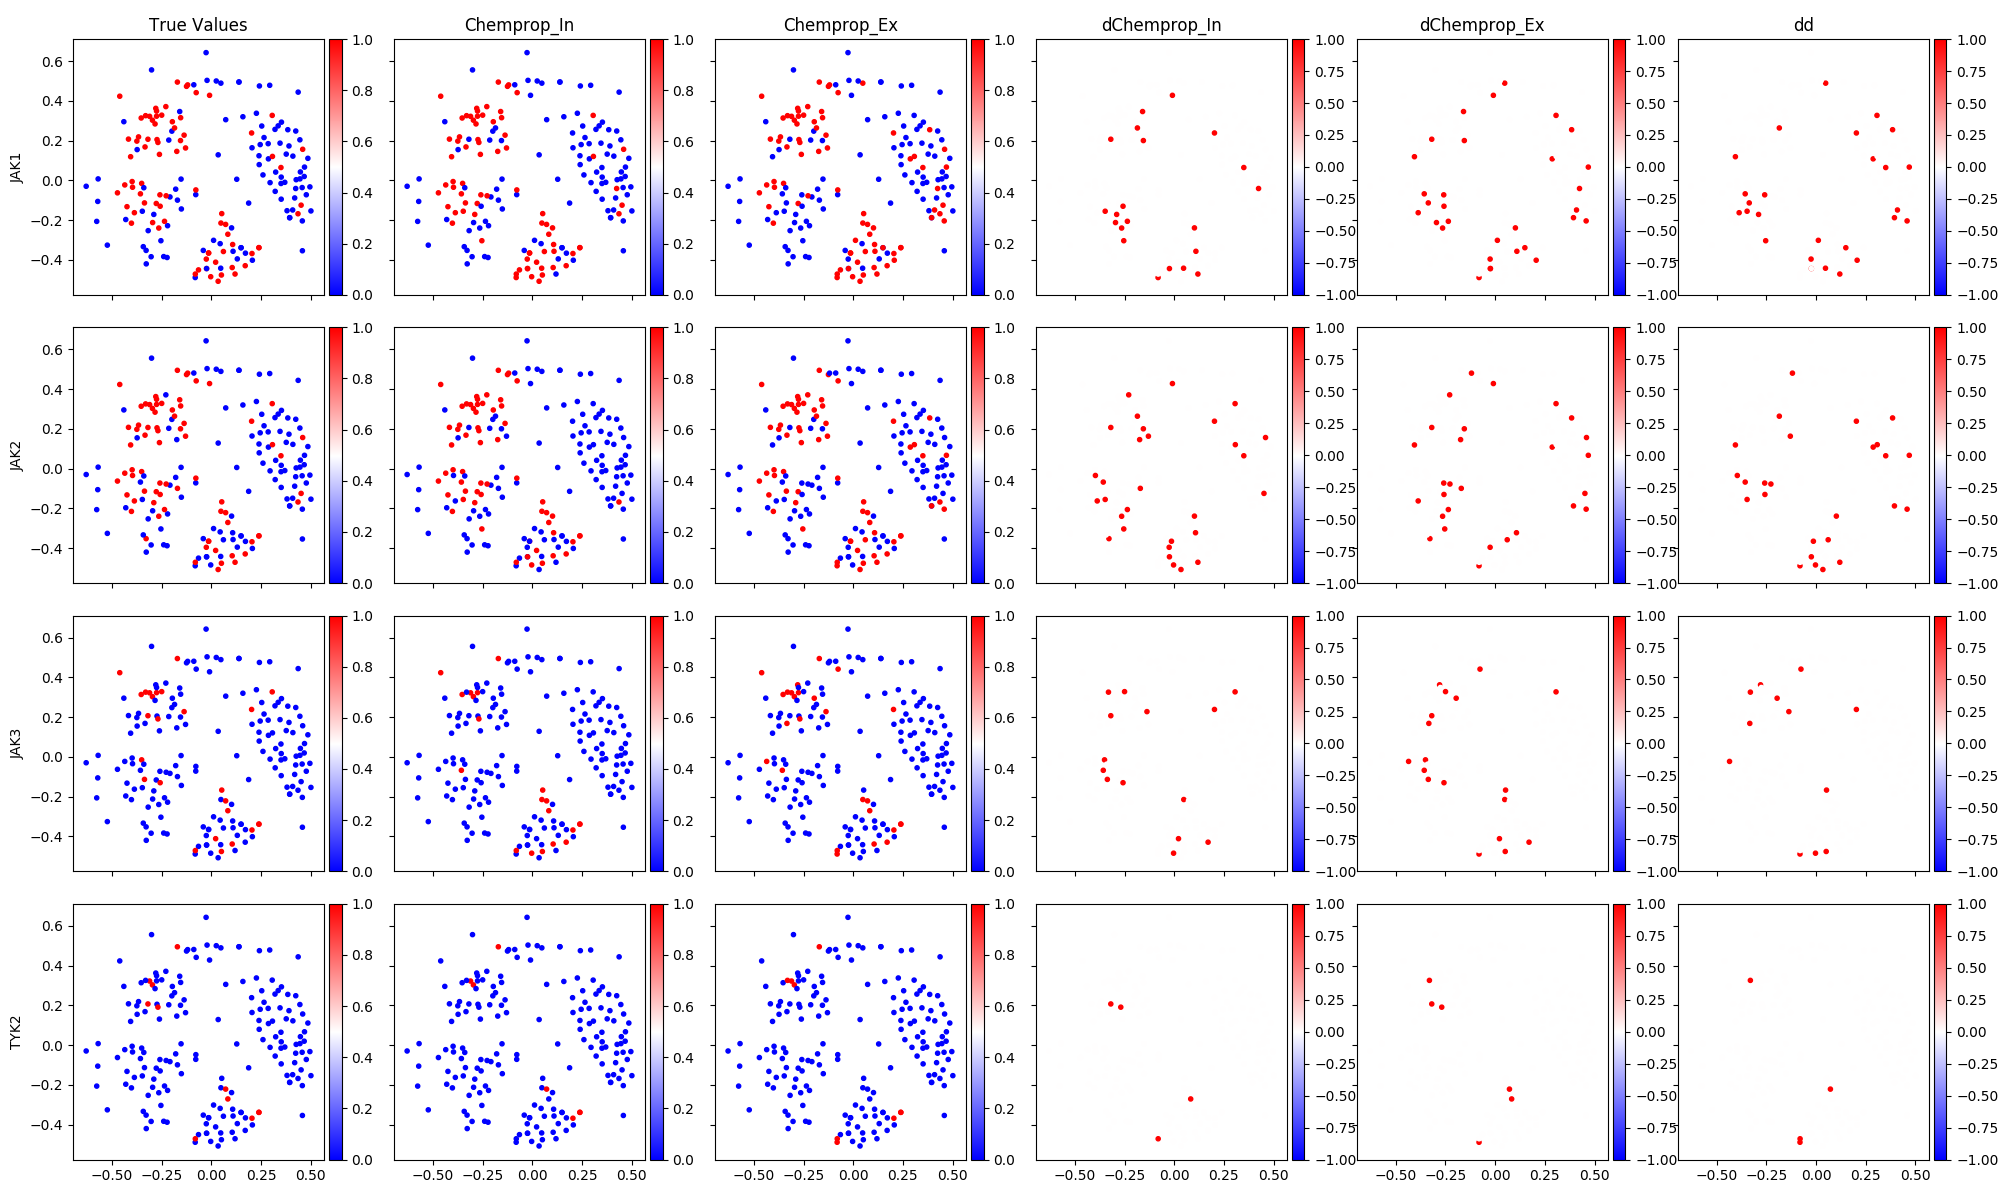

In [32]:
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'))
chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int','fold_0/model_0/val_preds_bin76_int.csv'))
lgb_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/val_preds_bin76_ext.csv'))
names = ['JAK1','JAK2','JAK3','TYK2']
diff_cp = test.filter(names).round(0).subtract(chemprop_preds.filter(names).round(0)).abs()
diff_lgb = test.filter(names).round(0).subtract(lgb_preds.filter(names).round(0)).abs()
cp_lgb = diff_cp.filter(names).subtract(diff_lgb.filter(names)).abs()
dfs = [test.filter(names),chemprop_preds.filter(names),lgb_preds.filter(names),diff_cp,diff_lgb,cp_lgb]
fps = get_fps([Chem.MolFromSmiles(smi) for smi in test['smiles']], bit=True)
dists = fps_distances(fps)
coords = get_embedding('mds', 2, dists)

f, axes = plt.subplots(4, 6, sharex = True, sharey=True, figsize=(20,12))
corrections = [(0,1),(0,1),(0,1),(-1,1),(-1,1),(-1,1)]
titles = ['True Values','Chemprop_In','Chemprop_Ex','dChemprop_In','dChemprop_Ex','dd']
for j, name in enumerate(names):
  for i, df in enumerate(dfs):
    f, ax, sc = plot_transformation_2D(coords,
                                       coloring=np.round(dfs[i][name]).tolist(),
                                       figure=(f, axes[j][i]),
                                       scale='binary', 
                                       color_correction=corrections[i])
    if i==0:
      ax.set_ylabel(names[j])
    if j==0:
      ax.set_title(titles[i])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_aspect('equal',adjustable='box')
    f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

# LEO Pharma and PubChem dataset MDS/PCA

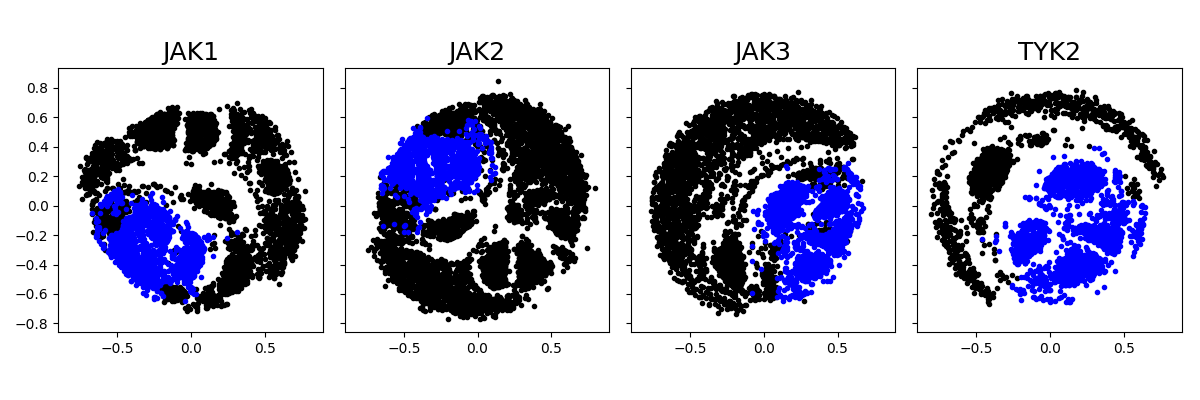

In [34]:
csvs = ['JAK1_20190311.csv', 
        'JAK2_20190311.csv', 
        'JAK3_20190311.csv', 
        'TYK2_20190311.csv']
sdfs = ['JAK1_20190311_sdf-d4409.gz', 
        'JAK2_20190311_sdf-3d49e.gz', 
        'JAK3_20190311_sdf-08df5.gz', 
        'TYK2_20190311_sdf-6ca3e.gz']
X_test = pd.read_csv(os.path.join(PARENT_DIR,'X_test_smiles.txt'), header=None, squeeze=True).astype(str).tolist()
X_train = pd.read_csv(os.path.join(PARENT_DIR,'X_train_smiles.txt'), header=None, squeeze=True).astype(str).tolist()
XTT = X_train + X_test
internal = [Chem.MolFromSmiles(smi) for smi in XTT]
f, axes = plt.subplots(1, 4, sharex = True, sharey=True, figsize=(12,4))
for j, file in enumerate(csvs):
  frame = external_prep('/'.join([PARENT_DIR, file]), 
                        '/'.join([PARENT_DIR, sdfs[j]]))
  frame.drop_duplicates(subset='cid', inplace=True)
  frame.dropna(subset=['acvalue'],inplace=True)
  external = frame['Molecule'].tolist()
  coords = pickle.load(open(os.path.join(PICKLES_DIR,'internal_vs_'+file[:-4]+'.p'),'rb'))
  f, ax = plot_transformation_2D(coords[:len(external)],
                                   figure=(f, axes[j]),
                                    )
  ax.scatter(coords[len(external):,0],coords[len(external):,1],color='b', marker='.')
  ax.set_title(file[:4], fontsize=18)
  ax.set_aspect('equal',adjustable='box')
f.tight_layout()
display(f)

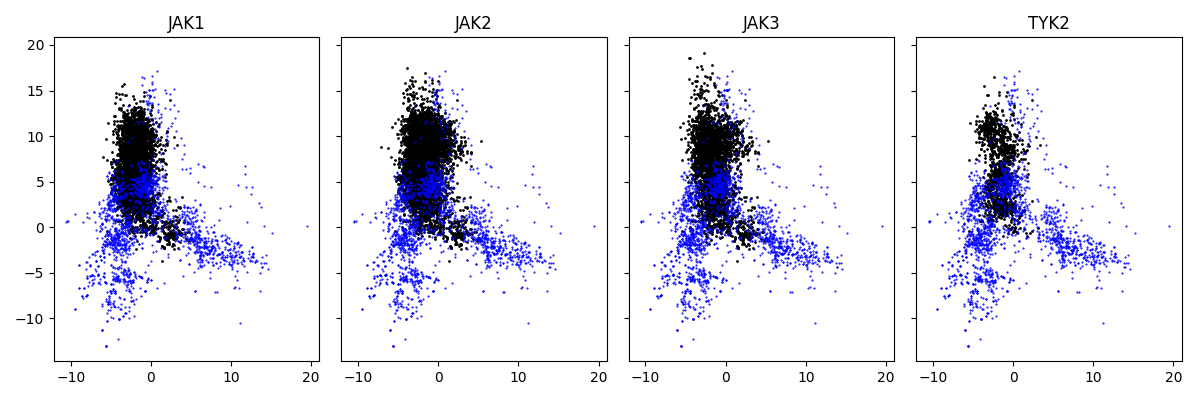

In [35]:

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import RandomizedPCA

csvs = ['JAK1_20190311.csv', 
        'JAK2_20190311.csv', 
        'JAK3_20190311.csv', 
        'TYK2_20190311.csv']
sdfs = ['JAK1_20190311_sdf-d4409.gz', 
        'JAK2_20190311_sdf-3d49e.gz', 
        'JAK3_20190311_sdf-08df5.gz', 
        'TYK2_20190311_sdf-6ca3e.gz']
XTT = X_train + X_test
train_num = len(XTT)
internal = [Chem.MolFromSmiles(smi) for smi in XTT]
f, axes = plt.subplots(1, 4, sharex = True, sharey=True, figsize=(12,4))
for j, file in enumerate(csvs):
  frame = external_prep('/'.join([PARENT_DIR, file]), 
                        '/'.join([PARENT_DIR, sdfs[j]]))
  frame.drop_duplicates(subset='cid', inplace=True)
  frame.dropna(subset=['acvalue'],inplace=True)
  external = frame['Molecule'].tolist()
  all_mols = internal + external 
  fps = get_fps(all_mols, morgan=True)

  v = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
  v.fit(fps)
  print(len(v.feature_names_))
  print(len(v.vocabulary_))

  X = v.transform(fps)
  X = X.toarray()
  
  scaler = StandardScaler(copy=False)
  scaler.fit(X[:train_num])
  scaler.transform(X)
  pca = RandomizedPCA(n_components=3,random_state=13)
  pca.fit(X[:train_num]) 
  Xred =pca.transform(X)
  ax=axes[j]
  ax.scatter(Xred[len(internal):,0], Xred[len(internal):,1],1,'k',marker='o')
  ax.scatter(Xred[:len(internal),0], Xred[:len(internal),1],1,'b',marker='.')
  ax.set_title(file[:4])
f.tight_layout()
display(f)

# Distance maps

In [37]:
csvs = ['JAK1_20190311.csv', 
        'JAK2_20190311.csv', 
        'JAK3_20190311.csv', 
        'TYK2_20190311.csv']
sdfs = ['JAK1_20190311_sdf-d4409.gz', 
        'JAK2_20190311_sdf-3d49e.gz', 
        'JAK3_20190311_sdf-08df5.gz', 
        'TYK2_20190311_sdf-6ca3e.gz']
all_d = []
sizes = []
all_fps = []
for j, file in enumerate(csvs):
  frame = external_prep('/'.join([PARENT_DIR, file]), 
                        '/'.join([PARENT_DIR, sdfs[j]]))
  frame.drop_duplicates(subset='cid', inplace=True)
  frame.dropna(subset=['acvalue'],inplace=True)
  internal = internal_f.dropna(subset=[names[j]])['Molecule'].tolist()
  external = frame['Molecule'].tolist()
  all_mols = internal + external
  fps = get_fps(all_mols, bit=True)
  all_fps.append(fps)
  all_d.append(fps_distances(fps))
  sizes.append((len(internal),len(external)))
  fps = get_fps(all_mols, morgan=True)
  v = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
  v.fit(fps)
  X = v.transform(fps)
  X = X.toarray()
  all_fps.append(X)

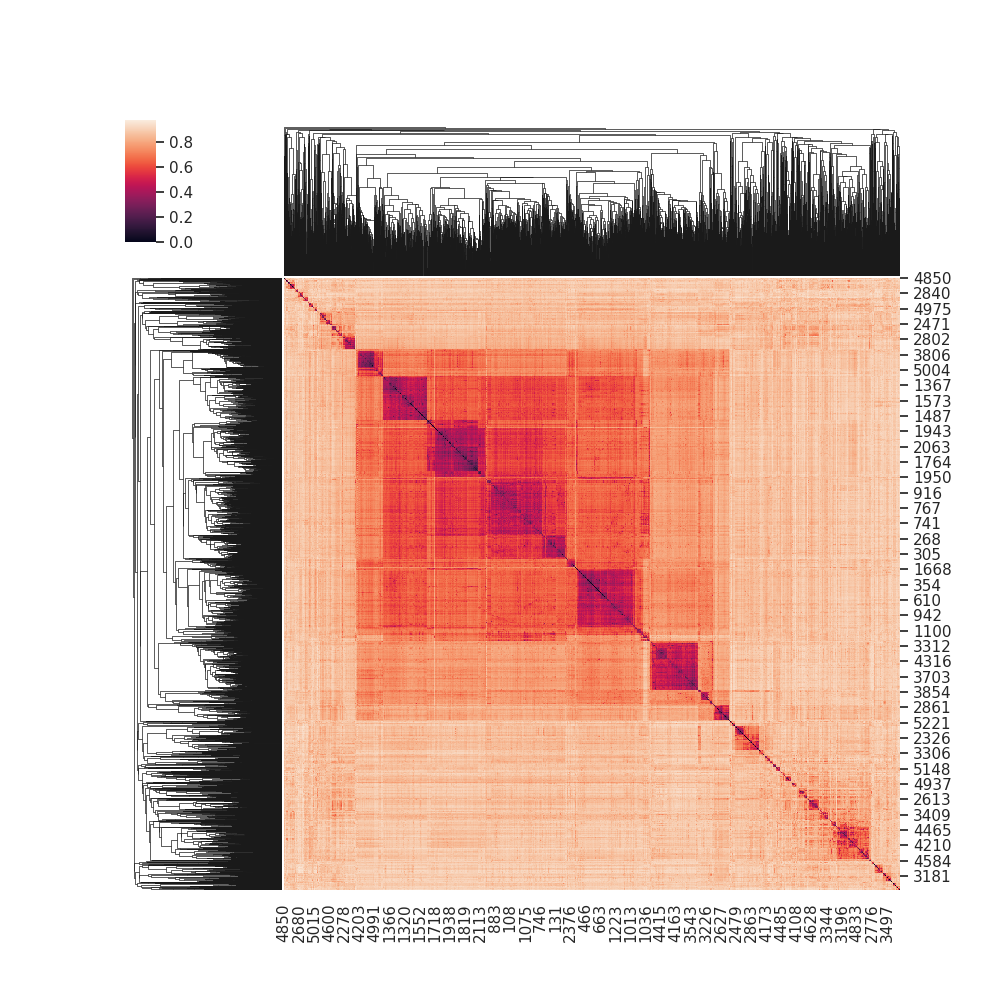

In [38]:
import seaborn as sns; sns.set(color_codes=True)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
l = hc.linkage(sp.distance.squareform(all_d[2]), method='average')
sns.clustermap(all_d[2], row_linkage=l, col_linkage=l)
display()

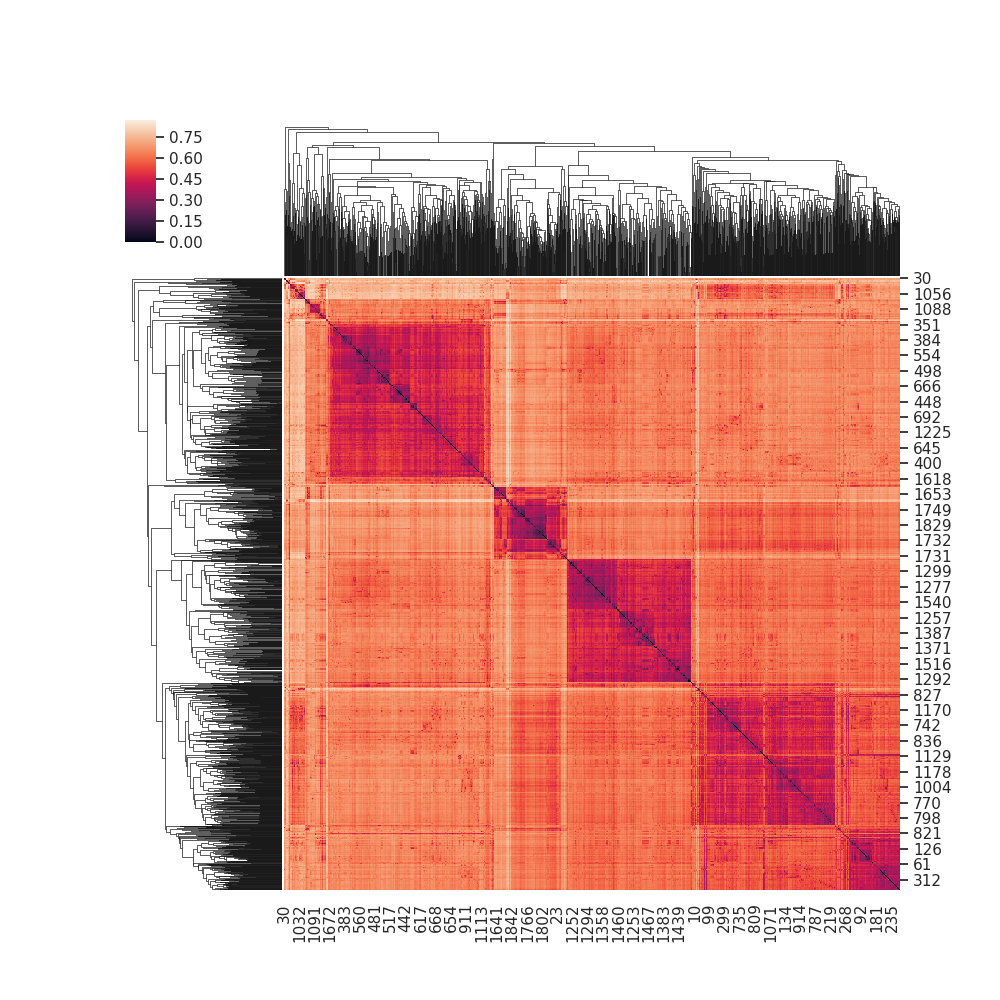

In [39]:
l = hc.linkage(sp.distance.squareform(all_d[1][:len(internal),:len(internal)]), method='average')
sns.clustermap(all_d[1][:len(internal),:len(internal)], row_linkage=l, col_linkage=l)
display()


In [40]:
# mean distance for LEO Pharma compounds
all_mols = internal_f['Molecule'].tolist()
fps = get_fps(all_mols, bit=True)
all_d = fps_distances(fps)
np.mean(list(all_d.flat))

Out[21]: 0.5981235383015513

# MOSES generated molecule PCA/MDS

In [42]:
names = ['aae','char_rnn']#,'vae'
model_smiles = pd.DataFrame({name:pd.read_csv(os.path.join(MOSES_DIR,name+'_generated.smi'),squeeze=True) for name in names})
X_test = pd.read_csv(os.path.join(PARENT_DIR,'X_test_smiles.txt'), header=None, squeeze=True).astype(str).tolist()
X_train = pd.read_csv(os.path.join(PARENT_DIR,'X_train_smiles.txt'), header=None, squeeze=True).astype(str).tolist()
model_jtnn = pd.DataFrame({'jtnn_vae':pd.read_csv(os.path.join(MOSES_DIR,'JT_VAE_generated-no_KL-30E.smi'),squeeze=True)})
model_jtnn_pretrain = pd.DataFrame({'jtnn_vae-pretrain':pd.read_csv(os.path.join(MOSES_DIR,'JT_VAE_generated-pretrain_filt-focused-E30E30.smi'),squeeze=True)})
model_smiles['jtnn_vae'] = model_jtnn['jtnn_vae']
model_smiles['jtnn_vae-pretrain'] = model_jtnn_pretrain['jtnn_vae-pretrain']
names.append('jtnn_vae')
names.append('jtnn_vae-pretrain')

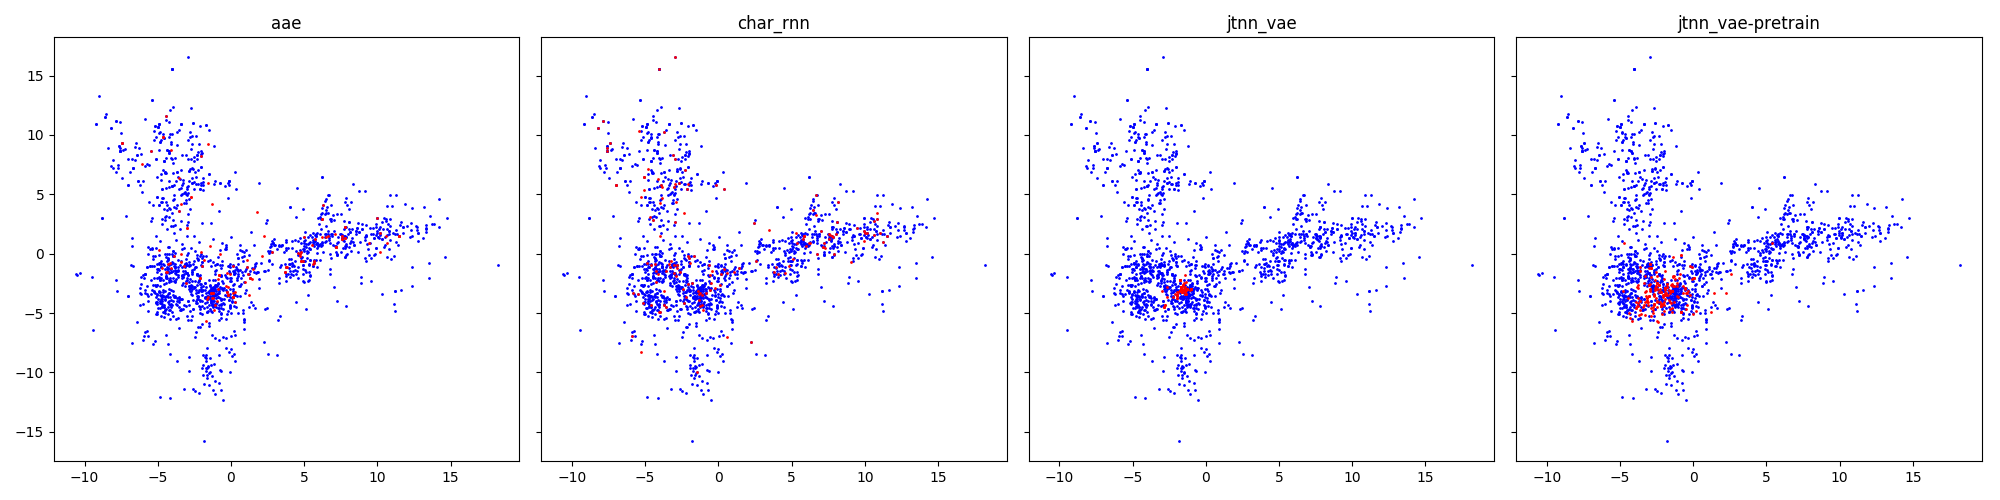

In [43]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import RandomizedPCA

f, axes = plt.subplots(1, len(names), sharex = True, sharey=True, figsize=(len(names)*5,5))
for i, name in enumerate(names):
  
  gen = [Chem.MolFromSmiles(smi) for smi in model_smiles[name]]
  train_num = len(X_train)
  all_fps = [Chem.MolFromSmiles(smi) for smi in X_train] + gen
  fps = get_fps(all_fps, morgan=True)

  v = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
  v.fit(fps)
  print(len(v.feature_names_))
  print(len(v.vocabulary_))

  X = v.transform(fps)
  X = X.toarray()

  
  scaler = StandardScaler(copy=False)
  scaler.fit(X[:train_num])
  scaler.transform(X)
  pca = RandomizedPCA(n_components=3,random_state=13)
  pca.fit(X[:train_num]) 
  Xred =pca.transform(X)
  ax=axes[i]
  ax.scatter(Xred[:train_num,0], Xred[:train_num,1],1,'b',marker='o')
  ax.scatter(Xred[train_num:,0], Xred[train_num:,1],1,'r',marker='o')
  ax.set_title(name)
f.tight_layout()
display(f)

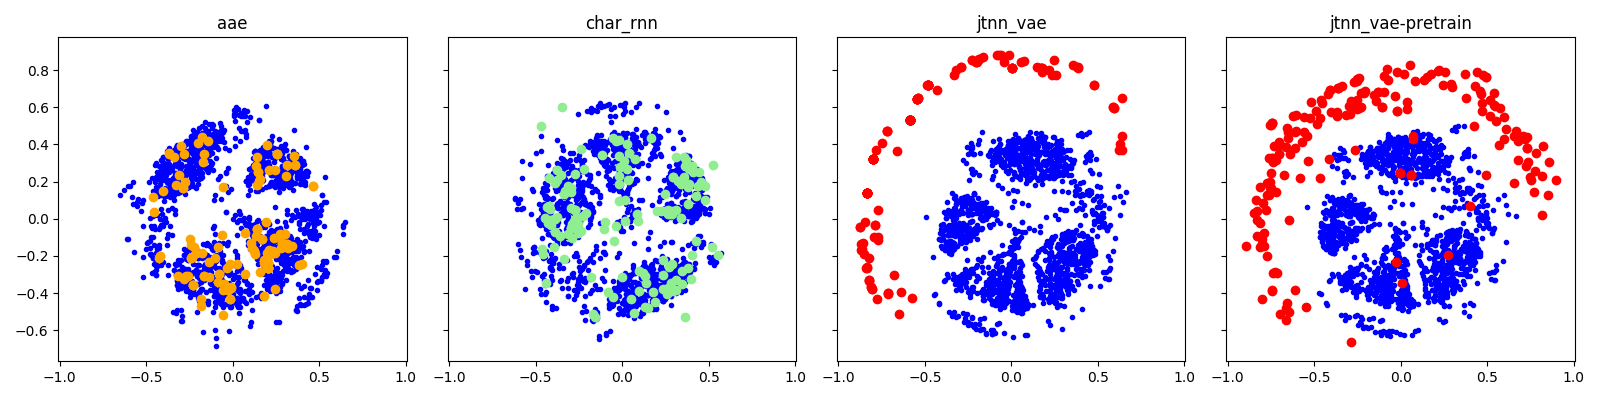

In [44]:

f, axes = plt.subplots(1, len(names), sharex = True, sharey=True, figsize=(len(names)*4,4))
colors = ['orange','lightgreen','red','red']
for i, name in enumerate(names):
  
  gen = [Chem.MolFromSmiles(smi) for smi in model_smiles[name]]
  train_num = len(X_train)
  all_fps = [Chem.MolFromSmiles(smi) for smi in X_train] + gen
  fps = get_fps(all_fps, bit=True)
  dists = fps_distances(fps)
  coords = get_embedding('mds', 2, dists)
  ax=axes[i]
  ax.scatter(coords[:train_num, 0], 
                   coords[:train_num, 1], 
                   marker = '.', 
                   c='b'
                )
  ax.scatter(coords[train_num:, 0], 
                   coords[train_num:, 1], 
                   marker = 'o', 
                   c=colors[i]
                )
  ax.set_title(name)
f.tight_layout()
display(f)

# Unused material

In [46]:
%sh mkdir /dbfs/FileStore/ZINC
cd /dbfs/FileStore/ZINC
wget http://zinc.docking.org/db/bysubset/13/13_t90.smi .

wget: /databricks/python/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /databricks/python/lib/libuuid.so.1: no version information available (required by wget)
wget: /databricks/python/lib/libssl.so.1.0.0: no version information available (required by wget)
wget: /databricks/python/lib/libssl.so.1.0.0: no version information available (required by wget)
--2019-04-29 12:14:03-- http://zinc.docking.org/db/bysubset/13/13_t90.smi
Resolving zinc.docking.org (zinc.docking.org)... 169.230.26.43
Connecting to zinc.docking.org (zinc.docking.org)|169.230.26.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5076990 (4.8M) [application/smil]
Saving to: ‘13_t90.smi’

 0K .......... .......... .......... .......... .......... 1% 241K 20s
 50K .......... .......... .......... .......... .......... 2% 342K 17s
 100K .......... .......... .......... .......... .......... 3% 343K 16s
 150K .......... .......... .......... .......... .......... 4% 347K 15s
 200K .......... .......... .......... .......... .......... 5% 348K 15s
 250K .......... .......... .......... .......... .......... 6% 14.6M 12s
 300K .......... .......... .......... .......... .......... 7% 348K 12s
 350K .......... .......... .......... .......... .......... 8% 20.4M 11s
 400K .......... .......... .......... .......... .......... 9% 350K 11s
 450K .......... .......... .......... .......... .......... 10% 19.9M 10s
 500K .......... .......... .......... .......... .......... 11% 342K 10s
 550K .......... .......... .......... .......... .......... 12% 21.3M 9s
 600K .......... .......... .......... .......... .......... 13% 351K 9s
 650K .......... .......... .......... .......... .......... 14% 22.2M 8s
 700K .......... .......... .......... .......... .......... 15% 349K 9s
 750K .......... .......... .......... .......... .......... 16% 18.0M 8s
 800K .......... .......... .......... .......... .......... 17% 9.91M 7s
 850K .......... .......... .......... .......... .......... 18% 361K 8s
 900K .......... .......... .......... .......... .......... 19% 21.0M 7s
 950K .......... .......... .......... .......... .......... 20% 12.8M 7s
 1000K .......... .......... .......... .......... .......... 21% 361K 7s
 1050K .......... .......... .......... .......... .......... 22% 20.1M 6s
 1100K .......... .......... .......... .......... .......... 23% 20.7M 6s
 1150K .......... .......... .......... .......... .......... 24% 361K 6s
 1200K .......... .......... .......... .......... .......... 25% 16.5M 6s
 1250K .......... .......... .......... .......... .......... 26% 21.8M 6s
 1300K .......... .......... .......... .......... .......... 27% 3.55M 5s
 1350K .......... .......... .......... .......... .......... 28% 394K 5s
 1400K .......... .......... .......... .......... .......... 29% 19.0M 5s
 1450K .......... .......... .......... .......... .......... 30% 19.4M 5s
 1500K .......... .......... .......... .......... .......... 31% 21.1M 5s
 1550K .......... .......... .......... .......... .......... 32% 3.64M 4s
 1600K .......... .......... .......... .......... .......... 33% 396K 5s
 1650K .......... .......... .......... .......... .......... 34% 20.0M 4s
 1700K .......... .......... .......... .......... .......... 35% 15.5M 4s
 1750K .......... .......... .......... .......... .......... 36% 4.36M 4s
 1800K .......... .......... .......... .......... .......... 37% 400K 4s
 1850K .......... .......... .......... .......... .......... 38% 10.1M 4s
 1900K .......... .......... .......... .......... .......... 39% 21.9M 4s
 1950K .......... .......... .......... .......... .......... 40% 20.9M 4s
 2000K .......... .......... .......... .......... .......... 41% 5.30M 3s
 2050K .......... .......... .......... .......... .......... 42% 13.1M 3s
 2100K .......... .......... .......... .......... .......... 43% 399K 3s
 2150K .......... .......... .......... .......... .......... 44% 18.9M 3s
 2200K ......

In [47]:
full_13 = ['13_p0.0.sdf.gz'
,'13_p0.1.sdf.gz'
,'13_p0.10.sdf.gz'
,'13_p0.11.sdf.gz'
,'13_p0.12.sdf.gz'
,'13_p0.13.sdf.gz'
,'13_p0.14.sdf.gz'
,'13_p0.15.sdf.gz'
,'13_p0.16.sdf.gz'
,'13_p0.17.sdf.gz'
,'13_p0.18.sdf.gz'
,'13_p0.19.sdf.gz'
,'13_p0.2.sdf.gz'
,'13_p0.20.sdf.gz'
,'13_p0.21.sdf.gz'
,'13_p0.22.sdf.gz'
,'13_p0.23.sdf.gz'
,'13_p0.24.sdf.gz'
,'13_p0.25.sdf.gz'
,'13_p0.26.sdf.gz'
,'13_p0.27.sdf.gz'
,'13_p0.28.sdf.gz'
,'13_p0.29.sdf.gz'
,'13_p0.3.sdf.gz'
,'13_p0.30.sdf.gz'
,'13_p0.31.sdf.gz'
,'13_p0.32.sdf.gz'
,'13_p0.33.sdf.gz'
,'13_p0.34.sdf.gz'
,'13_p0.35.sdf.gz'
,'13_p0.36.sdf.gz'
,'13_p0.37.sdf.gz'
,'13_p0.38.sdf.gz'
,'13_p0.39.sdf.gz'
,'13_p0.4.sdf.gz'
,'13_p0.40.sdf.gz'
,'13_p0.41.sdf.gz'
,'13_p0.42.sdf.gz'
,'13_p0.43.sdf.gz'
,'13_p0.44.sdf.gz'
,'13_p0.45.sdf.gz'
,'13_p0.46.sdf.gz'
,'13_p0.47.sdf.gz'
,'13_p0.48.sdf.gz'
,'13_p0.49.sdf.gz'
,'13_p0.5.sdf.gz'
,'13_p0.50.sdf.gz'
,'13_p0.51.sdf.gz'
,'13_p0.52.sdf.gz'
,'13_p0.53.sdf.gz'
,'13_p0.54.sdf.gz'
,'13_p0.55.sdf.gz'
,'13_p0.56.sdf.gz'
,'13_p0.57.sdf.gz'
,'13_p0.58.sdf.gz'
,'13_p0.59.sdf.gz'
,'13_p0.6.sdf.gz'
,'13_p0.60.sdf.gz'
,'13_p0.61.sdf.gz'
,'13_p0.62.sdf.gz'
,'13_p0.63.sdf.gz'
,'13_p0.64.sdf.gz'
,'13_p0.65.sdf.gz'
,'13_p0.66.sdf.gz'
,'13_p0.67.sdf.gz'
,'13_p0.68.sdf.gz'
,'13_p0.69.sdf.gz'
,'13_p0.7.sdf.gz'
,'13_p0.70.sdf.gz'
,'13_p0.71.sdf.gz'
,'13_p0.72.sdf.gz'
,'13_p0.73.sdf.gz'
,'13_p0.74.sdf.gz'
,'13_p0.75.sdf.gz'
,'13_p0.76.sdf.gz'
,'13_p0.77.sdf.gz'
,'13_p0.78.sdf.gz'
,'13_p0.79.sdf.gz'
,'13_p0.8.sdf.gz'
,'13_p0.80.sdf.gz'
,'13_p0.81.sdf.gz'
,'13_p0.82.sdf.gz'
,'13_p0.83.sdf.gz'
,'13_p0.84.sdf.gz'
,'13_p0.85.sdf.gz'
,'13_p0.86.sdf.gz'
,'13_p0.87.sdf.gz'
,'13_p0.88.sdf.gz'
,'13_p0.89.sdf.gz'
,'13_p0.9.sdf.gz'
,'13_p0.90.sdf.gz'
,'13_p0.91.sdf.gz'
,'13_p0.92.sdf.gz'
,'13_p0.93.sdf.gz'
,'13_p0.94.sdf.gz'
,'13_p0.95.sdf.gz'
,'13_p0.96.sdf.gz'
,'13_p0.97.sdf.gz'
,'13_p0.98.sdf.gz'
,'13_p1.0.sdf.gz'
,'13_p1.1.sdf.gz'
,'13_p1.10.sdf.gz'
,'13_p1.11.sdf.gz'
,'13_p1.12.sdf.gz'
,'13_p1.13.sdf.gz'
,'13_p1.14.sdf.gz'
,'13_p1.15.sdf.gz'
,'13_p1.16.sdf.gz'
,'13_p1.17.sdf.gz'
,'13_p1.2.sdf.gz'
,'13_p1.3.sdf.gz'
,'13_p1.4.sdf.gz'
,'13_p1.5.sdf.gz'
,'13_p1.6.sdf.gz'
,'13_p1.7.sdf.gz'
,'13_p1.8.sdf.gz'
,'13_p1.9.sdf.gz']

In [48]:
with open("/dbfs/FileStore/ZINC/full_files.txt", 'w+') as f:
  f.write('\n'.join(full_13))
  f.close()

In [49]:
%sh cd /dbfs/FileStore/ZINC
while read line; do wget zinc.docking.org/db/bysubset/13/$line .; done < full_files.txt

wget: /databricks/python/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /databricks/python/lib/libuuid.so.1: no version information available (required by wget)
wget: /databricks/python/lib/libssl.so.1.0.0: no version information available (required by wget)
wget: /databricks/python/lib/libssl.so.1.0.0: no version information available (required by wget)
--2019-04-29 12:25:42-- http://zinc.docking.org/db/bysubset/13/13_p0.0.sdf.gz
Resolving zinc.docking.org (zinc.docking.org)... 169.230.26.43
Connecting to zinc.docking.org (zinc.docking.org)|169.230.26.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92134448 (88M) [application/x-gzip]
Saving to: ‘13_p0.0.sdf.gz’

 0K .......... .......... .......... .......... .......... 0% 219K 6m51s
 50K .......... .......... .......... .......... .......... 0% 173K 7m45s
 100K .......... .......... .......... .......... .......... 0% 345K 6m36s
 150K .......... .......... .......... .......... .......... 0% 349K 6m1s
 200K .......... .......... .......... .......... .......... 0% 6.76M 4m52s
 250K .......... .......... .......... .......... .......... 0% 350K 4m46s
 300K .......... .......... .......... .......... .......... 0% 353K 4m41s
 350K .......... .......... .......... .......... .......... 0% 6.01M 4m7s
 400K .......... .......... .......... .......... .......... 0% 357K 4m8s
 450K .......... .......... .......... .......... .......... 0% 7.36M 3m44s
 500K .......... .......... .......... .......... .......... 0% 355K 3m46s
 550K .......... .......... .......... .......... .......... 0% 363K 3m48s
 600K .......... .......... .......... .......... .......... 0% 6.61M 3m31s
 650K .......... .......... .......... .......... .......... 0% 362K 3m34s
 700K .......... .......... .......... .......... .......... 0% 4.73M 3m21s
 750K .......... .......... .......... .......... .......... 0% 7.30M 3m9s
 800K .......... .......... .......... .......... .......... 0% 376K 3m11s
 850K .......... .......... .......... .......... .......... 1% 5.89M 3m1s
 900K .......... .......... .......... .......... .......... 1% 371K 3m4s
 950K .......... .......... .......... .......... .......... 1% 6.80M 2m56s
 1000K .......... .......... .......... .......... .......... 1% 7.01M 2m48s
 1050K .......... .......... .......... .......... .......... 1% 374K 2m51s
 1100K .......... .......... .......... .......... .......... 1% 6.76M 2m44s
 1150K .......... .......... .......... .......... .......... 1% 6.66M 2m38s
 1200K .......... .......... .......... .......... .......... 1% 378K 2m41s
 1250K .......... .......... .......... .......... .......... 1% 6.89M 2m35s
 1300K .......... .......... .......... .......... .......... 1% 7.04M 2m29s
 1350K .......... .......... .......... .......... .......... 1% 389K 2m32s
 1400K .......... .......... .......... .......... .......... 1% 6.09M 2m27s
 1450K .......... .......... .......... .......... .......... 1% 7.17M 2m23s
 1500K .......... .......... .......... .......... .......... 1% 392K 2m25s
 1550K .......... .......... .......... .......... .......... 1% 6.49M 2m21s
 1600K .......... .......... .......... .......... .......... 1% 6.21M 2m17s
 1650K .......... .......... .......... .......... .......... 1% 6.96M 2m13s
 1700K .......... .......... .......... .......... .......... 1% 400K 2m16s
 1750K .......... .......... .......... .......... .......... 2% 6.73M 2m12s
 1800K .......... .......... .......... .......... .......... 2% 5.84M 2m9s
 1850K .......... .......... .......... .......... .......... 2% 6.13M 2m6s
 1900K .......... .......... .......... .......... .......... 2% 407K 2m8s
 1950K .......... .......... .......... .......... .......... 2% 6.55M 2m5s
 2000K .......... .......... .......... .......... .......... 2% 6.10M 2m3s
 2050K .......... .......... .......... .......... .......... 2% 7.17M 2m0s
 2100K .......... .......... .......... .......... .......... 2% 407K 2m2s
 2150K ..

In [50]:
frame = PandasTools.LoadSDF("/dbfs/FileStore/tables/Homopiperazines_cleaned_Feb_2019.sdf",
                            smilesName='SMILES',molColName='Molecule', includeFingerprints=False)
#from pyspark.ml.image import ImageSchema
display(frame.head())

AlogP Canonical Smiles HBA HBD HLM Cl_app mL/min/kg 1065 ID JAK1 EC50 nM 1027 JAK2 EC50 nM 1024 JAK3 EC50 nM 1026 Leonumber LogD pH7.4 1192 Mol Psa Molecule Mw g/mol SMILES STAT6 EC50 nM 1075 STAT6 Emax % 1075 TYK2 EC50 nM 1025 ope 1024 ope 1025 ope 1026 ope 1027 ope 1065 ope 1075 -1.041 CN(C[C@H]1C[C@H](F)CN1S(=O)(=O)N)S(=O)(=O)N2CCCN(CC23CC3)c4ncnc5[nH]ccc45 7 2 179 ??? 47.2 49.3 73.5 LEO136377A 1.3 165.58 List() 516.613 CN(CC1CC(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2 1430.0 103.0 521.0 newline newline newline newline newline newline -1.041 CN(C[C@H]1C[C@@H](F)CN1S(=O)(=O)N)S(=O)(=O)N2CCCN(CC23CC3)c4ncnc5[nH]ccc45 7 2 200 26.4 16.6 99.8 LEO136376A 1.4 165.58 List() 516.613 CN(CC1CC(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2 1110.0 103.0 237.0 newline newline newline newline > newline -0.891 CN(C[C@H]1CCCN1S(=O)(=O)N)S(=O)(=O)N2CCCN(CC23CC3)c4ncnc5[nH]ccc45 7 2 200 31.2 24.1 148.0 LEO136375A 1.5 165.58 List() 498.623 CN(CC1CCCN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2 1310.0 105.0 293.0 newline newline newline newline > newline 0.929 O=C(CC#N)N1CCCN(CC12CC2)c3ncnc4[nH]ccc34 5 1 10 330.0 512.0 1350.0 LEO136218A 1.0 88.91 List() 310.354 N#CCC(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2 9600.0 104.0 3070.0 newline newline newline newline < newline -0.424 CNS(=O)(=O)N1CCN(C2CC12)c3ncnc4[nH]ccc34 5 2 newline 1610.0 1510.0 1450.0 LEO123958A newline 102.6 List() 308.359 CNS(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)C2CC21 47000.0 newline newline newline newline newline newline newline >

In [51]:
from molvs import Standardizer
import mordred

In [52]:
s = Standardizer()
df['Isomeric_canon'] = [Chem.MolToSmiles(s.standardize(Chem.MolFromSmiles(smi)), canonical = True) for smi in df['Canonical Smiles']]

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-756760143538014> in <module> () 
 1 s = Standardizer ( ) 
 ----> 2 df [ 'Isomeric_canon' ] = [ Chem . MolToSmiles ( s . standardize ( Chem . MolFromSmiles ( smi ) ) , canonical = True ) for smi in df [ 'Canonical Smiles' ] ] 

 NameError : name 'df' is not defined

In [53]:
y_vecs = []
frames = []
for j, file in enumerate(files):
  frame = PandasTools.LoadSDF(file,
                              smilesName='SMILES',molColName='Molecule', includeFingerprints=False)
  frame.replace('newline',np.nan, inplace=True)
  #drugs = [mol for mol in Chem.SDMolSupplier("Piperazines_cleaned_Feb_2019.sdf") if mol != None]

  #frame.dropna(subset=names,inplace=True)
  y_vecs.append([frame[name].tolist() for name in names])
  frames.append(frame)
  #fps = get_fps(frame['Molecule'].tolist(), bit=True)
  #dists = fps_distances(fps)
  #coords = get_embedding('mds', 2, dists)

In [54]:
import chemprop
from chemprop import features

In [55]:
full_internal = pd.concat(frames)

/local_disk0/tmp/1552812058804-0/PythonShell.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

 from __future__ import absolute_import

In [56]:
full_internal.reset_index(inplace=True, drop=True)
pickle.dump(full_internal, open('/'.join([PICKLES_DIR,'20190317-full_internal.p']),'wb+'))

In [57]:
full_descriptors = calc.pandas(full_internal.Molecule.tolist())

0%| | 0/2188 [00:00<?, ?it/s] 0%| | 1/2188 [00:01<46:20, 1.27s/it] 0%| | 7/2188 [00:01<33:37, 1.08it/s] 0%| | 9/2188 [00:02<25:50, 1.41it/s] 0%| | 10/2188 [00:02<20:36, 1.76it/s] 1%| | 12/2188 [00:02<15:18, 2.37it/s] 1%| | 14/2188 [00:03<12:14, 2.96it/s] 1%| | 15/2188 [00:03<12:03, 3.00it/s] 1%| | 18/2188 [00:04<11:21, 3.18it/s] 1%| | 21/2188 [00:04<09:43, 3.71it/s] 1%| | 25/2188 [00:05<07:59, 4.51it/s] 1%| | 26/2188 [00:05<08:47, 4.10it/s] 1%| | 27/2188 [00:05<07:17, 4.94it/s] 1%|▏ | 28/2188 [00:05<08:33, 4.20it/s] 1%|▏ | 30/2188 [00:06<08:25, 4.27it/s] 1%|▏ | 31/2188 [00:06<07:28, 4.81it/s] 2%|▏ | 33/2188 [00:06<08:00, 4.49it/s] 2%|▏ | 35/2188 [00:07<08:58, 4.00it/s] 2%|▏ | 39/2188 [00:08<07:37, 4.69it/s] 2%|▏ | 44/2188 [00:08<05:52, 6.08it/s] 2%|▏ | 45/2188 [00:08<10:46, 3.32it/s] 2%|▏ | 46/2188 [00:09<10:52, 3.28it/s] 2%|▏ | 50/2188 [00:09<08:24, 4.24it/s] 2%|▏ | 51/2188 [00:09<09:29, 3.75it/s] 2%|▏ | 52/2188 [00:10<08:45, 4.06it/s] 2%|▏ | 54/2188 [00:10<06:56, 5.12it/s] 3%|▎ | 56/2188 [00:10<06:20, 5.61it/s] 3%|▎ | 57/2188 [00:10<08:30, 4.17it/s] 3%|▎ | 61/2188 [00:11<07:46, 4.56it/s] 3%|▎ | 62/2188 [00:11<06:55, 5.12it/s] 3%|▎ | 63/2188 [00:12<10:25, 3.39it/s] 3%|▎ | 66/2188 [00:12<07:47, 4.54it/s] 3%|▎ | 67/2188 [00:12<10:14, 3.45it/s] 3%|▎ | 68/2188 [00:13<10:33, 3.35it/s] 3%|▎ | 71/2188 [00:13<07:55, 4.45it/s] 3%|▎ | 73/2188 [00:13<08:27, 4.17it/s] 3%|▎ | 74/2188 [00:14<07:34, 4.65it/s] 3%|▎ | 75/2188 [00:14<08:01, 4.39it/s] 4%|▎ | 78/2188 [00:14<06:13, 5.65it/s] 4%|▎ | 79/2188 [00:15<09:46, 3.59it/s] 4%|▎ | 81/2188 [00:15<09:05, 3.86it/s] 4%|▍ | 85/2188 [00:16<07:50, 4.47it/s] 4%|▍ | 86/2188 [00:16<08:28, 4.14it/s] 4%|▍ | 88/2188 [00:16<07:00, 5.00it/s] 4%|▍ | 91/2188 [00:17<06:59, 5.00it/s] 4%|▍ | 92/2188 [00:17<05:56, 5.87it/s] 4%|▍ | 93/2188 [00:17<06:49, 5.12it/s] 4%|▍ | 96/2188 [00:17<05:28, 6.38it/s] 4%|▍ | 97/2188 [00:18<09:59, 3.49it/s] 5%|▍ | 99/2188 [00:18<08:23, 4.15it/s] 5%|▍ | 102/2188 [00:18<07:07, 4.88it/s] 5%|▍ | 103/2188 [00:19<07:29, 4.63it/s] 5%|▍ | 104/2188 [00:19<09:14, 3.76it/s] 5%|▍ | 107/2188 [00:19<07:16, 4.76it/s] 5%|▍ | 108/2188 [00:19<06:41, 5.18it/s] 5%|▌ | 110/2188 [00:20<05:52, 5.90it/s] 5%|▌ | 111/2188 [00:20<09:19, 3.71it/s] 5%|▌ | 113/2188 [00:20<07:12, 4.80it/s] 5%|▌ | 116/2188 [00:21<06:35, 5.23it/s] 5%|▌ | 117/2188 [00:21<06:13, 5.55it/s] 5%|▌ | 118/2188 [00:21<06:01, 5.73it/s] 5%|▌ | 120/2188 [00:21<05:11, 6.65it/s] 6%|▌ | 122/2188 [00:22<05:36, 6.15it/s] 6%|▌ | 123/2188 [00:22<07:22, 4.66it/s] 6%|▌ | 124/2188 [00:22<06:15, 5.50it/s] 6%|▌ | 128/2188 [00:22<05:23, 6.37it/s] 6%|▌ | 129/2188 [00:23<08:53, 3.86it/s] 6%|▌ | 132/2188 [00:23<06:42, 5.11it/s] 6%|▌ | 134/2188 [00:23<06:30, 5.26it/s] 6%|▌ | 135/2188 [00:24<08:40, 3.94it/s] 6%|▋ | 137/2188 [00:24<07:41, 4.44it/s] 6%|▋ | 140/2188 [00:24<06:22, 5.36it/s] 6%|▋ | 141/2188 [00:25<07:31, 4.53it/s] 6%|▋ | 142/2188 [00:25<07:11, 4.74it/s] 7%|▋ | 145/2188 [00:25<06:18, 5.40it/s] 7%|▋ | 146/2188 [00:26<06:45, 5.04it/s] 7%|▋ | 147/2188 [00:26<07:10, 4.74it/s] 7%|▋ | 151/2188 [00:26<06:21, 5.35it/s] 7%|▋ | 153/2188 [00:27<07:24, 4.58it/s] 7%|▋ | 157/2188 [00:27<06:03, 5.59it/s] 7%|▋ | 159/2188 [00:28<05:32, 6.10it/s] 7%|▋ | 160/2188 [00:28<11:31, 2.93it/s] 8%|▊ | 166/2188 [00:29<08:57, 3.76it/s] 8%|▊ | 167/2188 [00:29<11:16, 2.99it/s] 8%|▊ | 172/2188 [00:30<08:55, 3.76it/s] 8%|▊ | 173/2188 [00:30<08:29, 3.96it/s] 8%|▊ | 176/2188 [00:30<07:26, 4.50it/s] 8%|▊ | 178/2188 [00:31<07:35, 4.41it/s] 8%|▊ | 180/2188 [00:31<07:10, 4.67it/s] 8%|▊ | 183/2188 [00:32<05:47, 5.78it/s] 8%|▊ | 184/2188 [00:32<08:28, 3.94it/s] 9%|▊ | 187/2188 [00:32<06:18, 5.28it/s] 9%|▊ | 189/2188 [00:33<06:36, 5.04it/s] 9%|▊ | 190/2188 [00:33<09:26, 3.53it/s] 9%|▉ | 194/2188 [00:34<07:46, 4.27it/s] 9%|▉ | 196/2188 [00:34<06:33, 5.06it/s] 9%|▉ | 197/2188 [00:34<06:17, 5.28it/s] 9%|▉ | 199/2188 [00:34<06:43, 4.93it/s] 9%|▉ | 202/2188 [00:35<06:14, 5.30it/s] 9%|▉ | 203/2188

In [58]:
pickle.dump(full_descriptors, open('/'.join([PICKLES_DIR,'20190317-full_descriptors.p']),'wb+'))

In [59]:
import random
def distCompare(dmat,coords,nPicks=5000,seed=0xf00d):
    """ picks a random set of pairs of points to compare distances """
    nPts=len(coords)
    random.seed(seed)
    res=[]
    keep=set()
    if nPicks>0:
        while len(res)<nPicks:
            idx1 = random.randint(0,nPts-1)
            idx2 = random.randint(0,nPts-1)
            if idx1==idx2: 
                continue
            if idx1>idx2: 
                idx1,idx2=idx2,idx1
            if (idx1,idx2) in keep: 
                continue
            keep.add((idx1,idx2))
            p1 = coords[idx1]
            p2 = coords[idx2]
            v = p1-p2
            d = np.sqrt(v.dot(v))
            res.append((dmat[idx1][idx2],d))
    else:
        for idx1 in range(nPts):
            for idx2 in range(idx1+1,nPts):
                p1 = coords[idx1]
                p2 = coords[idx2]
                v = p1-p2
                d = np.sqrt(v.dot(v))
                res.append((dmat[idx1][idx2],d))
    return res

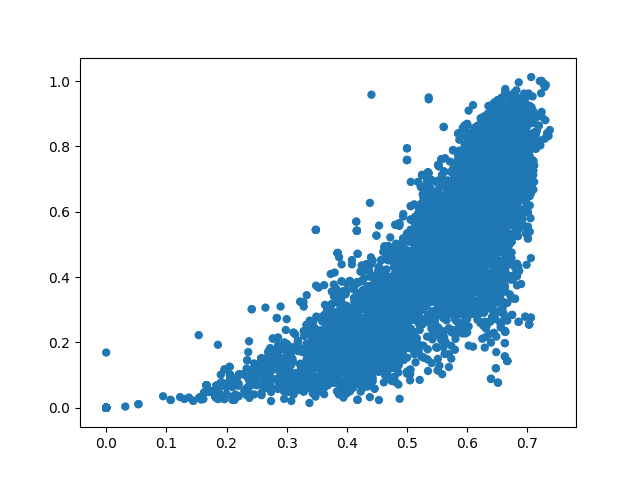

In [60]:
mds3 =MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results3 = mds3.fit(dists)
coords3=results3.embedding_
d = distCompare(dists,coords3,nPicks=-1)
plt.close()
plt.scatter([x for x,y in d],[y for x,y in d],edgecolors='none')

display(plt.show())

# XGB

In [62]:
calc = Calculator(descriptors, ignore_3D = True)

In [63]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

In [64]:
full_df = pd.concat([full_internal, full_descriptors], axis=1)
m_cols = full_descriptors.columns
temp = full_df.dropna(subset=names)
Xs_all = temp[m_cols]
ys_all = temp[names].apply(pd.to_numeric,errors='coerce').apply(lambda x: x*1e-9).apply(np.log10)
ys_all = -ys_all

corr_matrix = Xs_all.corr().abs()
#upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

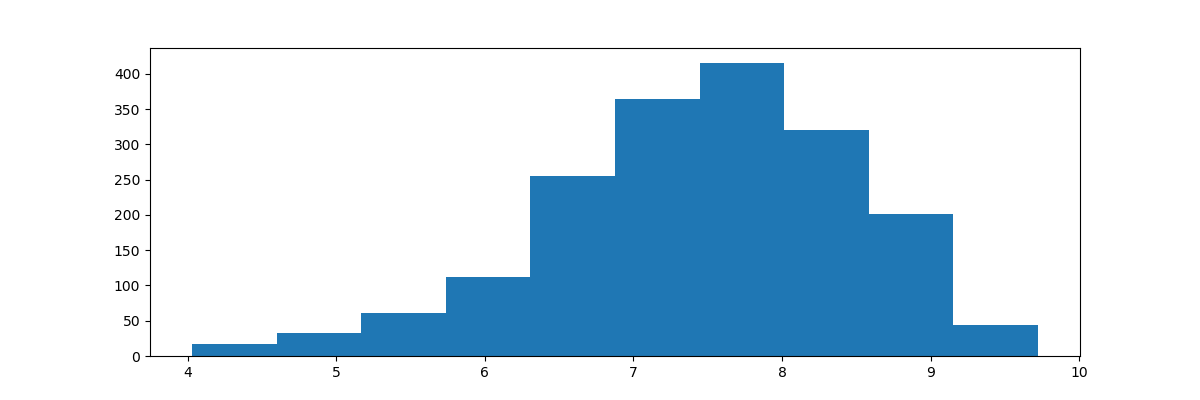

In [65]:
plt.subplot(111)
plt.hist(ys_all[names[0]])
display(plt.show())

In [66]:
X_train, X_test, y_train, y_test = train_test_split(Xs_all, ys_all[names[0]], test_size=0.2, random_state=7)
gbr = XGBRegressor(
  learning_rate =0.1,
  n_estimators=150,
  max_depth=6,
  min_child_weight=1,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)


def filter_x_by_corr(thresh):
  to_drop = [column for column in upper.columns if any(upper[column] > thresh)]
  X_train.f = X_train.drop(full_descriptors[to_drop], axis=1)
  X_test.f = X_test.drop(full_descriptors[to_drop], axis=1)
  return X_train.f, X_test.f

thresholds=[0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9]
results = defaultdict(list)
for thresh in thresholds:
  X_train.f, X_test.f = filter_x_by_corr(thresh)
  gbr.fit(X_train.f, y_train)
  y_pred = gbr.predict(X_test.f)
  #predictions = [round(value) for value in y_pred]
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  var_score = explained_variance_score(y_test, y_pred)
  results['Threshold'].append(thresh)
  results['N_descriptors'].append(X_train.f.shape[1])
  results['RMSE'].append(round(rmse, 2))
  results['Explained_var'].append(round(var_score, 2))
display(pd.DataFrame.from_dict(results))

Threshold N_descriptors RMSE Explained_var 0.2 194 0.88 0.3 0.3 198 0.83 0.37 0.4 203 0.72 0.53 0.5 219 0.64 0.62 0.55 234 0.63 0.64 0.6 247 0.62 0.65 0.65 266 0.62 0.65 0.7 292 0.58 0.7 0.75 337 0.6 0.67 0.8 388 0.62 0.66 0.9 547 0.6 0.67

In [68]:
X_train.f, X_test.f = filter_x_by_corr(0.7)
print("Number of descriptors before filtering:",X_train.shape[1])
print("Number of descriptors after filtering:",X_train.f.shape[1])
# Correlation of the selected descriptors
#display(upper.drop(upper[to_drop], axis=1).drop(upper[to_drop], axis=0))

Number of descriptors before filtering: 1229
Number of descriptors after filtering: 292

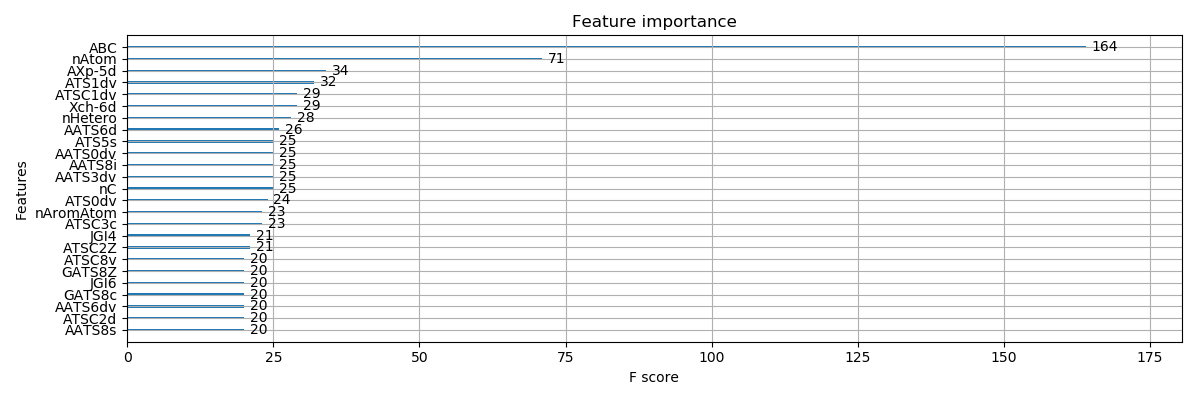

In [69]:
from xgboost import plot_importance
gbr.fit(X_train.f, y_train)
plot_importance(gbr, max_num_features=25)
plt.tight_layout()
display(plt.show())

In [70]:
full_df = pd.concat([full_internal, filt_descriptors], axis=1)
m_cols = filt_descriptors.columns
Xs = []
ys = []
for name in names:
  temp = full_df.dropna(subset=[name])
  Xs.append(temp[m_cols])
  y = temp[name].apply(pd.to_numeric,errors='coerce')
  y = y*1e-9
  #y = -np.log10(np.array(y).astype(float)*1e-9)
  y = y.apply(np.log10)
  y = -y
  ys.append(y)

In [71]:
from sklearn import ensemble
from pyspark import SparkContext, SparkConf
from spark_sklearn import GridSearchCV
n_est=300
tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
#conf = SparkConf()
#sc.stop()
#sc = SparkContext(conf=conf)
sc = SparkContext.getOrCreate()
clf = GridSearchCV(estimator=gbr, sc=sc, cv=3, param_grid=tuned_parameters, scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)

In [72]:
#RUNNING
from xgboost import XGBRegressor
n_est=300
tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = XGBRegressor()
#conf = SparkConf()
#sc.stop()
#sc = SparkContext(conf=conf)
sc = SparkContext.getOrCreate()
clf = GridSearchCV(estimator=gbr, sc=sc, cv=3, param_grid=tuned_parameters, scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)

## Hyperparameter tuning XGBRegressor

In [74]:
#Import libraries:
from pyspark import SparkContext, SparkConf
from spark_sklearn import GridSearchCV #Perforing grid search
from xgboost import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions

import matplotlib.pylab as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


/databricks/python/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
 "This module will be removed in 0.20.", DeprecationWarning)

In [75]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("Model Report")
    print("RMSE : %.2g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("Explained Variance : %2g" % metrics.explained_variance_score(dtrain[target], dtrain_predictions))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    print("n_estimators : %0g" % alg.get_params()['n_estimators'])

In [76]:
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
import xgboost as xgb
#temp = full_df.dropna(subset=names)
Xs_all = temp[m_cols]
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
Xs_filt = Xs_all.drop(full_descriptors[to_drop], axis=1)
predictors = Xs_filt.columns
#ys_all = temp[names].apply(pd.to_numeric,errors='coerce').apply(np.log10)
#ys_all = -ys_all
plt.close()
plt.subplot(111)
for name in names:
  gbr1 = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,
    seed=27)
  train = Xs_filt
  train[name] = ys_all[name]
  target = name
  print('\nPredicting activity: ', name)
  modelfit(gbr1, train, predictors)


Predicting activity: JAK1 EC50 nM 1027
Model Report
RMSE : 0.27
Explained Variance : 0.932249
n_estimators : 388

Predicting activity: JAK2 EC50 nM 1024
Model Report
RMSE : 0.32
Explained Variance : 0.879361
n_estimators : 225

Predicting activity: JAK3 EC50 nM 1026
Model Report
RMSE : 0.24
Explained Variance : 0.914771
n_estimators : 352

Predicting activity: TYK2 EC50 nM 1025
Model Report
RMSE : 0.33
Explained Variance : 0.878971
n_estimators : 240

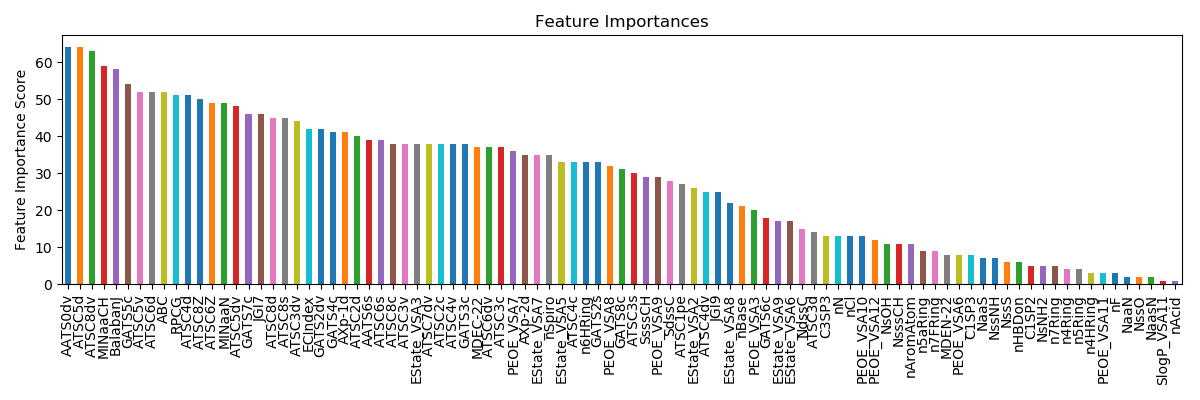

In [77]:
plt.tight_layout()
display(plt.show())

In [78]:
train = Xs_filt
train[names[0]] = ys_all[names[0]]
target = names[0]
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gbr1 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=388,
  max_depth=3,
  min_child_weight=1,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)

sc = SparkContext.getOrCreate()
gsearch1 = GridSearchCV(estimator = gbr1, sc=sc, param_grid = param_test1, n_jobs=4, iid=False, cv=5, scoring='neg_mean_squared_error')#, scoring='rmse'
gsearch1.fit(train[predictors],train[target])
display(pd.DataFrame(gsearch1.cv_results_))

split0_test_score split1_test_score split2_test_score split3_test_score split4_test_score mean_test_score std_test_score rank_test_score split0_train_score split1_train_score split2_train_score split3_train_score split4_train_score mean_train_score std_train_score mean_fit_time std_fit_time mean_score_time std_score_time param_max_depth param_min_child_weight params -0.8226513567089548 -0.40819464062483646 -1.0067014950598145 -0.6065637578157151 -0.34754769008989755 -0.6383317880598438 0.2482730957754175 2 -0.05907590242761896 -0.06713113454840436 -0.06525317282658853 -0.04349167061361295 -0.06921834170073941 -0.06083404442339284 0.009309430416054603 1.4997923851013184 0.045292716191306336 0.0053020954132080075 4.31464120494908E-5 3 1 Map(max_depth -> 3, min_child_weight -> 1) -0.8496683657284957 -0.41296082115443533 -1.0636760240920597 -0.6067515832875113 -0.3617779373153131 -0.658966946315563 0.2652256525392308 6 -0.05824749941542863 -0.06660060907659486 -0.06383781033991826 -0.041666425984683376 -0.06836026891879102 -0.05974252274708323 0.009664891583218935 1.4614919185638429 0.007990816112947849 0.005324649810791016 1.3681358029908781E-4 3 3 Map(max_depth -> 3, min_child_weight -> 3) -0.8326235694870361 -0.428714917293987 -0.9278736413686736 -0.5919723861645104 -0.3815941607261263 -0.6325557350080666 0.21606462141965252 1 -0.05744758921219593 -0.06640161593163292 -0.06334589134913522 -0.044210379005595844 -0.06686330081412582 -0.05965375526253715 0.008420309714102658 1.4526829242706298 0.012999745700725259 0.00531620979309082 9.733090931771797E-5 3 5 Map(max_depth -> 3, min_child_weight -> 5) -0.8502845548715512 -0.4281626449979651 -0.9973545266146714 -0.5934281994394057 -0.36818205496299705 -0.6474823961773181 0.24189704970197698 4 -0.03381800540648741 -0.04000673610943001 -0.03865219443228816 -0.013814623244795253 -0.03881460702760835 -0.03302123324412184 0.009834600830984506 1.9787160873413085 0.024770020956175812 0.006729555130004883 5.589528206485621E-5 5 1 Map(max_depth -> 5, min_child_weight -> 1) -0.9819590385682949 -0.4146862438297443 -0.9746291448792683 -0.5919402816821654 -0.36639932714534595 -0.6659228072209638 0.26588946666649477 8 -0.03287499982499764 -0.03916208064249153 -0.03776013150656363 -0.013714313461999982 -0.03791006230851902 -0.03228431754891436 0.009530279377958167 1.971008586883545 0.030981695757264914 0.006641912460327149 1.579737396816225E-4 5 3 Map(max_depth -> 5, min_child_weight -> 3) -0.8959713761904115 -0.4557760363029494 -0.948147949535527 -0.5491961364301535 -0.38391607206183603 -0.6466015141041755 0.23152597818695292 3 -0.031971420664105764 -0.03827340594846993 -0.03667888423952269 -0.01352209010147444 -0.03710915226845553 -0.03151099064440567 0.009247587113086214 1.9438466548919677 0.014659542446596025 0.006568717956542969 6.856056127337379E-5 5 5 Map(max_depth -> 5, min_child_weight -> 5) -0.9039151493549348 -0.4537056892721044 -1.0203695327417275 -0.6327472882084545 -0.4034620538222468 -0.6828399426798936 0.24325470440384803 12 -0.029041611616708426 -0.03520948427555353 -0.03355107898533315 -0.01172077328098259 -0.034092849368456316 -0.028723159505406805 0.00875668126433172 2.4665120601654054 0.011296940682105547 0.007694625854492187 1.9929109967695605E-4 7 1 Map(max_depth -> 7, min_child_weight -> 1) -0.9373466986077835 -0.40331669131440256 -0.9705774068890894 -0.5844126241716913 -0.385522229373644 -0.6562351300713221 0.25307961774157106 5 -0.028563638110173595 -0.03475381601626654 -0.033115047804661034 -0.011532754080185 -0.03364377059198355 -0.028321805320653946 0.008655633704141855 2.4377696037292482 0.012081669882509683 0.0074805736541748045 6.951697053826117E-5 7 3 Map(max_depth -> 7, min_child_weight -> 3) -0.8940220005098775 -0.454177667279592 -0.986879729263826 -0.5843091999655143 -0.3948385255750188 -0.6628454245187657 0.23663419418940201 7 -0.028276097935464473 -0.03438129009013187 -0.03276052959245713 -0.011506012367156053 -0.03341329816753307 -0.028067445630548516 0.00854

In [79]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}

gbr2 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=388,
  max_depth=3,
  min_child_weight=3,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)

sc = SparkContext.getOrCreate()
gsearch2 = GridSearchCV(estimator = gbr2, sc=sc, param_grid = param_test2, n_jobs=4, iid=False, cv=5, scoring='neg_mean_squared_error')#, scoring='rmse'
gsearch2.fit(train[predictors],train[target])
display(pd.DataFrame(gsearch2.cv_results_))

split0_test_score split1_test_score split2_test_score split3_test_score split4_test_score mean_test_score std_test_score rank_test_score split0_train_score split1_train_score split2_train_score split3_train_score split4_train_score mean_train_score std_train_score mean_fit_time std_fit_time mean_score_time std_score_time param_max_depth param_min_child_weight params -0.8432173423024301 -0.41667341648461115 -0.9984839094145737 -0.6322490133886759 -0.38768664577342066 -0.6556620654727422 0.23756193696231268 8 -0.11424250679938534 -0.1308339361246097 -0.12390330661335545 -0.11930488681548071 -0.14124763929159662 -0.1259064551288856 0.009415657165408172 1.24291090965271 0.03975879206016605 0.004879808425903321 1.0442544334470206E-4 2 4 Map(max_depth -> 2, min_child_weight -> 4) -0.8216405701591607 -0.42587288702691845 -0.9945331545878237 -0.6157213200591088 -0.3939671056345387 -0.65034700749351 0.23027106267574748 6 -0.11367910231876992 -0.13425629351220772 -0.12216349513112074 -0.12082716183973988 -0.1430606957888224 -0.1267973497181321 0.010481759722546186 1.2086057186126709 0.020417310091947468 0.004845285415649414 4.990792830233445E-5 2 5 Map(max_depth -> 2, min_child_weight -> 5) -0.8008581274079195 -0.4130917948985318 -1.0083088083009197 -0.6335073143205712 -0.38473041654173595 -0.6480992922939357 0.23575019469581376 4 -0.11486911418661457 -0.13322167169381252 -0.12258517877336839 -0.12450004274555569 -0.14032289043668 -0.12709977956720625 0.008821084420838177 1.2038797855377197 0.005883230885903102 0.004865694046020508 6.764543083787747E-5 2 6 Map(max_depth -> 2, min_child_weight -> 6) -0.8227578388624445 -0.39477961766800895 -0.9738847752835189 -0.5997774434393113 -0.3426333649548554 -0.6267666080416279 0.2425620180999389 2 -0.057828876498064466 -0.06680037536373439 -0.06320200466321518 -0.044204812307216575 -0.06810617865781762 -0.06002844949800965 0.00867647112626584 1.4594738006591796 0.011979238477516863 0.005364179611206055 2.1711197508804747E-4 3 4 Map(max_depth -> 3, min_child_weight -> 4) -0.8326235694870361 -0.428714917293987 -0.9278736413686736 -0.5919723861645104 -0.3815941607261263 -0.6325557350080666 0.21606462141965252 3 -0.05744758921219593 -0.06640161593163292 -0.06334589134913522 -0.044210379005595844 -0.06686330081412582 -0.05965375526253715 0.008420309714102658 1.4663332462310792 0.014800688363691876 0.00526123046875 1.2269210035600837E-4 3 5 Map(max_depth -> 3, min_child_weight -> 5) -0.7410595913302584 -0.41526358673813074 -0.9537240290910024 -0.5846385028585505 -0.360131438575156 -0.6109634297186196 0.21740191252423116 1 -0.05723065265363629 -0.0648821492203983 -0.062046724815076074 -0.044866888769941146 -0.06613702252897119 -0.059032687597604605 0.007716079092479407 1.4653748989105224 0.01220939834692604 0.005262994766235351 5.8739602953790386E-5 3 6 Map(max_depth -> 3, min_child_weight -> 6) -0.9263591360420563 -0.44236392939268787 -0.9176333052981307 -0.6015348929790364 -0.35295910607466247 -0.6481700739573149 0.23735210642076365 5 -0.039151379386690374 -0.04562309986080469 -0.04349261999848757 -0.01983021000288654 -0.04472551439186141 -0.03856456472814611 0.009626903408061051 1.714712905883789 0.006475105621372536 0.005927896499633789 7.771108664442726E-5 4 4 Map(max_depth -> 4, min_child_weight -> 4) -0.9305794594953325 -0.4363920734300927 -0.9711888687631227 -0.5983674492944643 -0.36618433985947857 -0.6605424381684981 0.24906906793987846 9 -0.038990456441244305 -0.04510989356627437 -0.042888672350004174 -0.01995584209202391 -0.043688933317221186 -0.03812675955335359 0.00930919937272138 1.7102864265441895 0.028141017732814518 0.006024980545043945 3.062017004976924E-4 4 5 Map(max_depth -> 4, min_child_weight -> 5) -0.8675601739814739 -0.427101958435697 -1.0031579695668396 -0.5927240718739482 -0.3632944930241482 -0.6507677333764214 0.24787664283062985 7 -0.038184556855574855 -0.04452562756658607 -0.04296987288664728 -0.020482693942959023 -0.04393864177988265 -0.03802027860632998 0.00904918708455735

In [80]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gbr3 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=388,
  max_depth=3,
  min_child_weight=6,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)

sc = SparkContext.getOrCreate()
gsearch3 = GridSearchCV(estimator = gbr3, sc=sc, param_grid = param_test3, n_jobs=4, iid=False, cv=5, scoring='neg_mean_squared_error')#, scoring='rmse'
gsearch3.fit(train[predictors],train[target])
display(pd.DataFrame(gsearch3.cv_results_))

split0_test_score split1_test_score split2_test_score split3_test_score split4_test_score mean_test_score std_test_score rank_test_score split0_train_score split1_train_score split2_train_score split3_train_score split4_train_score mean_train_score std_train_score mean_fit_time std_fit_time mean_score_time std_score_time param_gamma params -0.7410595913302584 -0.41526358673813074 -0.9537240290910024 -0.5846385028585505 -0.360131438575156 -0.6109634297186196 0.21740191252423116 1 -0.05723065265363629 -0.0648821492203983 -0.062046724815076074 -0.044866888769941146 -0.06613702252897119 -0.059032687597604605 0.007716079092479407 1.4789744853973388 0.031483335992392385 0.005317020416259766 8.555147000856815E-5 0.0 Map(gamma -> 0.0) -0.7856781851805994 -0.4097791825921028 -0.9702462093585174 -0.5873798461456682 -0.379833969275903 -0.6265834785105582 0.224873985196663 4 -0.05798409959193037 -0.0648007589334921 -0.06215815472263286 -0.04531727253600442 -0.06773177819634998 -0.059598412796081954 0.007827199895842083 1.461456060409546 0.021161072389780378 0.005263757705688476 2.4314674344250746E-5 0.1 Map(gamma -> 0.1) -0.7698264607572967 -0.414242337523902 -0.9491674492295562 -0.5853493647626394 -0.37664950056625 -0.6190470225679288 0.2161254195646852 2 -0.05864842976701056 -0.06584061020452099 -0.06370361433268752 -0.04562830184313009 -0.06846344622471953 -0.060456880474413735 0.00808440671728657 1.4499704360961914 0.007919194638038776 0.0052206993103027345 4.0955676481524325E-5 0.2 Map(gamma -> 0.2) -0.8305550243729888 -0.41725742522368886 -0.9392203008208476 -0.5857914908166965 -0.3616046387322454 -0.6268857759932935 0.22584989955361012 5 -0.06173227542602575 -0.0675735827751042 -0.0659044741442079 -0.04874626449089962 -0.07046138151867269 -0.06288359567098203 0.0076122821196021 1.4560206890106202 0.016088568076978352 0.005427026748657226 6.426488943548838E-4 0.3 Map(gamma -> 0.3) -0.8168035716292432 -0.4066945326501809 -0.9412468857993277 -0.5875560631772725 -0.3433463954762581 -0.6191294897464565 0.2302244412894279 3 -0.06532070105491787 -0.07209186056302243 -0.07059033608645374 -0.05490730867322914 -0.07378345103281662 -0.06733873148208797 0.0068309925853905235 1.4568515777587892 0.010080856222153581 0.005068588256835938 7.176144173991073E-5 0.4 Map(gamma -> 0.4)

In [81]:
plt.close()
plt.subplot(111)
gbr4 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=1000,
  max_depth=3,
  min_child_weight=6,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)
modelfit(gbr4, train, predictors)

Model Report
RMSE : 0.3
Explained Variance : 0.911311
n_estimators : 277

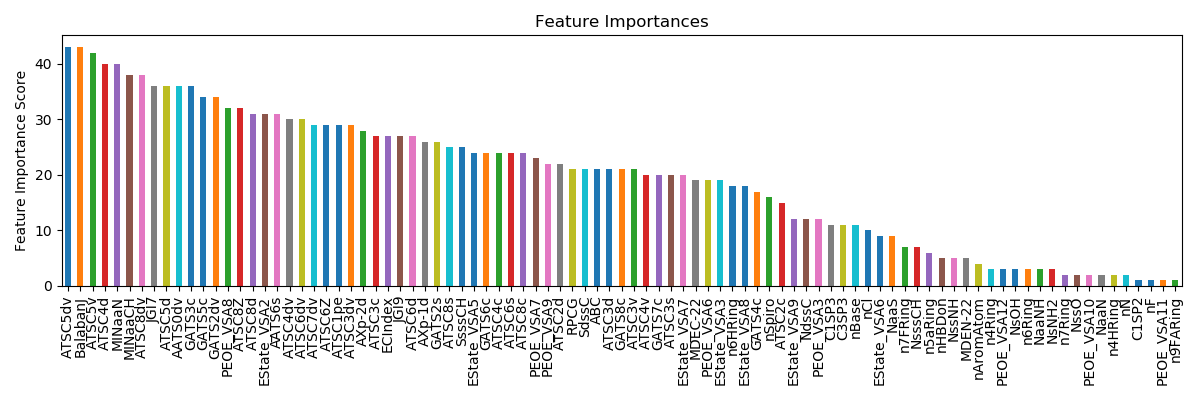

In [82]:
plt.tight_layout()
display(plt.show())

In [83]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gbr5 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=277,
  max_depth=3,
  min_child_weight=6,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)

sc = SparkContext.getOrCreate()
gsearch5 = GridSearchCV(estimator = gbr5, sc=sc, param_grid = param_test5, n_jobs=4, iid=False, cv=5, scoring='neg_mean_squared_error')#, scoring='rmse'
gsearch5.fit(train[predictors],train[target])
display(pd.DataFrame(gsearch5.cv_results_))


split0_test_score split1_test_score split2_test_score split3_test_score split4_test_score mean_test_score std_test_score rank_test_score split0_train_score split1_train_score split2_train_score split3_train_score split4_train_score mean_train_score std_train_score mean_fit_time std_fit_time mean_score_time std_score_time param_colsample_bytree param_subsample params -0.788089325027251 -0.4347605486129138 -0.9522336264634205 -0.6160543390733227 -0.39449264897552566 -0.6371260976304868 0.2108788636147872 12 -0.08168178131036245 -0.09383235301535332 -0.0869772026473585 -0.07498803791107188 -0.09437465052684434 -0.0863708050821981 0.007371001151437957 1.1124361038208008 0.045803884569583835 0.004845571517944336 6.706666742825811E-5 0.6 0.6 Map(colsample_bytree -> 0.6, subsample -> 0.6) -0.7645509443831658 -0.4146405279415837 -0.9010706917929927 -0.6480628513868136 -0.40215250662302476 -0.6260955044255161 0.19500128214899015 8 -0.07808752522558533 -0.08708053202175077 -0.08539090831252576 -0.07217475847549243 -0.09252858146570898 -0.08305246110021265 0.007133940713604183 1.0849409580230713 0.008555483369146133 0.004809236526489258 2.982752687862011E-5 0.6 0.7 Map(colsample_bytree -> 0.6, subsample -> 0.7) -0.7605428967205873 -0.43154941122909973 -0.9616971294269324 -0.5876586282670763 -0.37850305439286835 -0.6239902240073129 0.2150860237720326 7 -0.07780615381541343 -0.08738747537529773 -0.08488782620356349 -0.07077609203519167 -0.08959558651082407 -0.08209062678805809 0.006907687822907611 8.699637651443481 15.202211774144484 0.004837179183959961 4.511711132661883E-5 0.6 0.8 Map(colsample_bytree -> 0.6, subsample -> 0.8) -0.7332901446418365 -0.41789392679074067 -0.9404743897397239 -0.6115518971799451 -0.36892639862122584 -0.6144273513946944 0.20944660793064085 4 -0.07668555764370662 -0.08865583925742936 -0.0833037333053117 -0.0694162543648545 -0.09096239887874283 -0.081804756690009 0.007908575882315787 24.12886300086975 18.808609540641342 0.005129861831665039 4.152410500858656E-4 0.6 0.9 Map(colsample_bytree -> 0.6, subsample -> 0.9) -0.794738817574767 -0.40164800538745316 -0.9256274401339935 -0.609408995699616 -0.4246708002171775 -0.6312188118026014 0.20457552984173877 10 -0.07981802816158362 -0.09124551876098652 -0.08608478547383992 -0.07425137469205398 -0.09233871357326165 -0.08474768413234512 0.006871789325755985 16.39352512359619 18.688929072134904 0.0048563480377197266 3.130681979003291E-5 0.7 0.6 Map(colsample_bytree -> 0.7, subsample -> 0.6) -0.7911718678092474 -0.41267104956636 -0.951793636781318 -0.6524258460854833 -0.33665276654991727 -0.6289430333584651 0.22948172929264604 9 -0.07781965581650101 -0.08730962895811463 -0.08243835845818917 -0.06912553363316715 -0.08888608889028052 -0.0811158531512505 0.007143124267265913 1.1509059429168702 0.011059817555320938 0.0048370361328125 6.122429420789178E-5 0.7 0.7 Map(colsample_bytree -> 0.7, subsample -> 0.7) -0.7825151180609731 -0.40578681051014354 -0.895878950354454 -0.5858715128436429 -0.3952896110846917 -0.613068400570781 0.19991344455402665 2 -0.07481142871036203 -0.08605567188966141 -0.08183716398640929 -0.07029043645767738 -0.09061795820280455 -0.08072253184938293 0.007367143337656619 1.1650930881500243 0.01531911335720455 0.0048161506652832035 5.489669456454249E-5 0.7 0.8 Map(colsample_bytree -> 0.7, subsample -> 0.8) -0.6556372206510334 -0.40783387705637186 -0.9093765832347411 -0.5946277954714841 -0.38176513156612285 -0.5898481215959507 0.1912470677365564 1 -0.07541168722206507 -0.08761876455504707 -0.08276170352174396 -0.06881871057771574 -0.08995000619195556 -0.08091217441370549 0.007830564978277886 1.1687108993530273 0.017210422898547843 0.004831552505493164 5.5895607491983725E-5 0.7 0.9 Map(colsample_bytree -> 0.7, subsample -> 0.9) -0.7805561931319984 -0.42594582448226626 -0.9854576126684078 -0.6190707884682608 -0.42284768381008275 -0.6467756205122032 0.2155364520401369 15 -0.07939358402004289 -0.09084553651308097 -0.08394375455150155 -0.07153942908227846 -0.089861

In [84]:
param_test6 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}

gbr6 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=277,
  max_depth=3,
  min_child_weight=6,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)

sc = SparkContext.getOrCreate()
gsearch6 = GridSearchCV(estimator = gbr6, sc=sc, param_grid = param_test6, n_jobs=4, iid=False, cv=5, scoring='neg_mean_squared_error')#, scoring='rmse'
gsearch6.fit(train[predictors],train[target])
display(pd.DataFrame(gsearch6.cv_results_))

split0_test_score split1_test_score split2_test_score split3_test_score split4_test_score mean_test_score std_test_score rank_test_score split0_train_score split1_train_score split2_train_score split3_train_score split4_train_score mean_train_score std_train_score mean_fit_time std_fit_time mean_score_time std_score_time param_colsample_bytree param_subsample params -0.7907360123876416 -0.39727008394898 -0.9411214699054219 -0.6111796079438725 -0.38587046539850944 -0.6252355279168851 0.21754805647959166 7 -0.07780033108286727 -0.08966038110843161 -0.08230490551795822 -0.0664786281840828 -0.08941593502458048 -0.08113203618358407 0.008585498174463026 1.2315924167633057 0.027757092283189087 0.004848337173461914 4.5563680558696716E-5 0.65 0.85 Map(colsample_bytree -> 0.65, subsample -> 0.85) -0.6837772015133136 -0.40814643165839476 -0.9942941209169692 -0.6184978090084615 -0.3763557236243298 -0.6162142573442939 0.22286259693186322 6 -0.07690520633594256 -0.08657242066255019 -0.0831399420958067 -0.07010439555283735 -0.09133622326605442 -0.08161163758263823 0.0074307437632757135 1.1976995944976807 0.07249708893464392 0.004832267761230469 6.833677072477761E-5 0.65 0.9 Map(colsample_bytree -> 0.65, subsample -> 0.9) -0.7319901743015959 -0.41862540316449354 -0.9353623914229885 -0.5959336994264085 -0.3921769140601045 -0.6148177164751182 0.20243281863996507 5 -0.07655905251752876 -0.08853069039933327 -0.08583512776152567 -0.07113910789438707 -0.09273498667218735 -0.08295979304899244 0.00794424237096922 1.2112676620483398 0.1337140252303298 0.004815053939819336 6.98193492871217E-5 0.65 0.95 Map(colsample_bytree -> 0.65, subsample -> 0.95) -0.7513485440606165 -0.4152779122527076 -0.9398662380410642 -0.5880307825451903 -0.3676941947497869 -0.612443534329873 0.21254304638708313 3 -0.07497672274747154 -0.08631660250493477 -0.08127033861965209 -0.06967411046236646 -0.09092382750019126 -0.08063232036692322 0.007624977357801302 1.1695849895477295 0.012638885195087044 0.004978561401367187 1.7993048162633763E-4 0.7 0.85 Map(colsample_bytree -> 0.7, subsample -> 0.85) -0.6556372206510334 -0.40783387705637186 -0.9093765832347411 -0.5946277954714841 -0.38176513156612285 -0.5898481215959507 0.1912470677365564 1 -0.07541168722206507 -0.08761876455504707 -0.08276170352174396 -0.06881871057771574 -0.08995000619195556 -0.08091217441370549 0.007830564978277886 1.1803963661193848 0.037528614923147886 0.004878997802734375 1.076969208944125E-4 0.7 0.9 Map(colsample_bytree -> 0.7, subsample -> 0.9) -0.7355068620335273 -0.40770631004678576 -0.897899505468993 -0.5992526392351131 -0.3783270034011341 -0.6037384640371106 0.19654652559387395 2 -0.07519603210054611 -0.08843605049729086 -0.0848859851140887 -0.07033697560971659 -0.09074250846293683 -0.0819195103569158 0.00785456344425159 1.1865923404693604 0.020190991081055838 0.00485539436340332 1.0353572144728068E-4 0.7 0.95 Map(colsample_bytree -> 0.7, subsample -> 0.95) -0.8170668535320299 -0.424682282744104 -0.9591668689845582 -0.5889064581409482 -0.3654801481279508 -0.6310605223059182 0.22678360082941137 8 -0.07396146752738215 -0.08731138285063558 -0.08184858662591557 -0.06897840365541368 -0.08884503481909774 -0.08018897509568894 0.00765335397227959 1.184871006011963 0.012367938012613294 0.004842090606689453 4.89545745715988E-5 0.75 0.85 Map(colsample_bytree -> 0.75, subsample -> 0.85) -0.7720324698984595 -0.4048628559223974 -0.9103687563191821 -0.616289575938674 -0.3624887773800371 -0.61320848709175 0.20966976467562987 4 -0.07697720141212351 -0.08593883778707329 -0.08189195708069012 -0.06846189165664693 -0.09022077174248026 -0.08069813193580283 0.0075251815302371135 1.2048188209533692 0.015195313498250877 0.004864501953125 9.445100588979814E-5 0.75 0.9 Map(colsample_bytree -> 0.75, subsample -> 0.9) -0.8295678961140217 -0.37774645681755786 -0.9822787712962694 -0.6022704772922051 -0.387475696637984 -0.6358678596316076 0.2395722576514378 9 -0.07635081193186921 -0.08743041454865609 -0.08483180006361889 -0.07168866088

In [85]:
plt.close()
plt.subplot(111)
gbr7 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=1000,
  max_depth=3,
  min_child_weight=6,
  gamma=0,
  subsample=0.9,
  colsample_bytree=0.7,
  nthread=4,
  scale_pos_weight=1,
  seed=27)
modelfit(gbr7, train, predictors)

Model Report
RMSE : 0.26
Explained Variance : 0.932919
n_estimators : 405

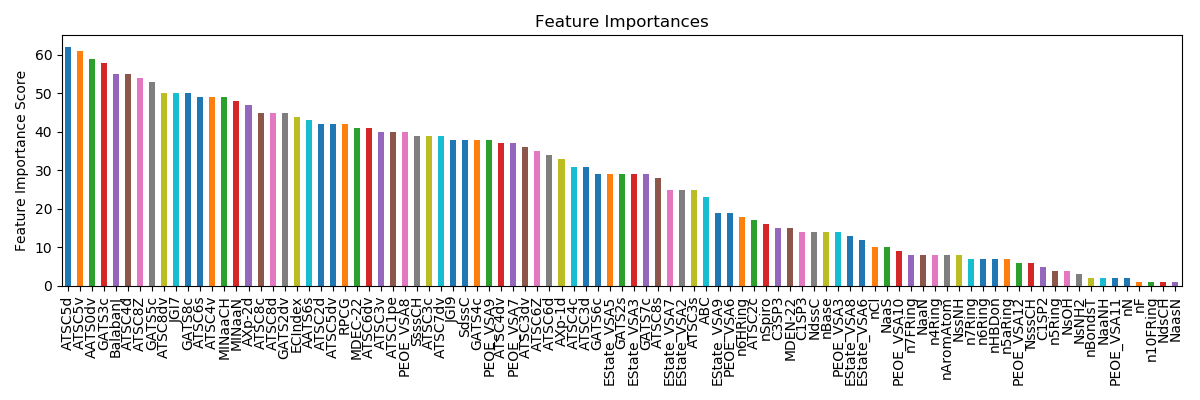

In [86]:
plt.tight_layout()
display(plt.show())

In [87]:
param_test8 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gbr8 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=405,
  max_depth=3,
  min_child_weight=6,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)

sc = SparkContext.getOrCreate()
gsearch8 = GridSearchCV(estimator = gbr8, sc=sc, param_grid = param_test8, n_jobs=4, iid=False, cv=5, scoring='neg_mean_squared_error')#, scoring='rmse'
gsearch8.fit(train[predictors],train[target])
pd.DataFrame(gsearch8.cv_results_).filter(['rank_test_score','param_reg_alpha'])

Out[68]: 
 rank_test_score param_reg_alpha
0 2 1e-05
1 1 0.01
2 3 0.1
3 4 1
4 5 100

In [88]:
param_test9 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gbr9 = XGBRegressor(
  learning_rate =0.1,
  n_estimators=405,
  max_depth=3,
  min_child_weight=6,
  gamma=0,
  subsample=0.8,
  colsample_bytree=0.8,
  nthread=4,
  scale_pos_weight=1,
  seed=27)

sc = SparkContext.getOrCreate()
gsearch9 = GridSearchCV(estimator = gbr9, sc=sc, param_grid = param_test9, n_jobs=4, iid=False, cv=5, scoring='neg_mean_squared_error')#, scoring='rmse'
gsearch9.fit(train[predictors],train[target])
pd.DataFrame(gsearch9.cv_results_).filter(['rank_test_score','param_reg_alpha'])

Out[69]: 
 rank_test_score param_reg_alpha
0 3 0
1 2 0.001
2 1 0.005
3 4 0.01
4 5 0.05

In [89]:
plt.close()
plt.subplot(111)
gbr7 = XGBRegressor(
  learning_rate =0.01,
  n_estimators=5000,
  max_depth=3,
  min_child_weight=6,
  gamma=0,
  #reg_alpha=0.005,
  subsample=0.9,
  colsample_bytree=0.7,
  nthread=4,
  scale_pos_weight=1,
  seed=27)
modelfit(gbr7, train, predictors)

Model Report
RMSE : 0.3
Explained Variance : 0.913697
n_estimators : 2903

In [90]:
plt.tight_layout()
display(plt.show())

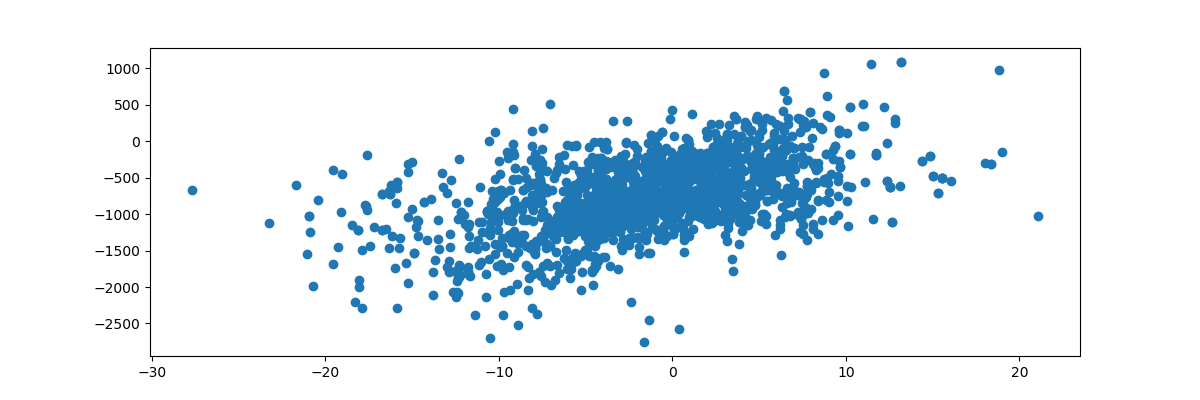

In [91]:
plt.close()
plt.scatter(train['ATSC5d'], train['ATSC5v'], )
display(plt.show())

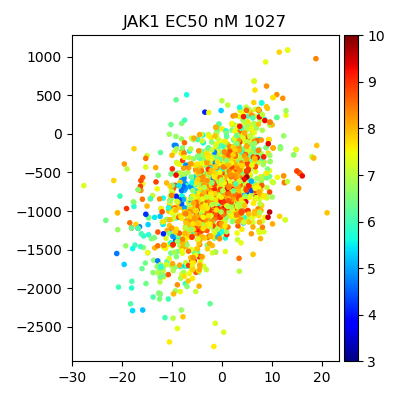

In [92]:
f, axes = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(4,4))
f, ax, sc = plot_transformation_2D(np.array(train.filter(['ATSC5d','ATSC5v'])),
                                 coloring=train[target].tolist(),
                                 figure=(f, axes),
                                 scale=None, 
                                 color_correction=(3,10))

ax.set_title(target)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

In [93]:
train.filter['ATSC5d','ATSC5v']

--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-1215863119991835> in <module> () 
 ----> 1 train . filter [ 'ATSC5d' , 'ATSC5v' ] 

 TypeError : 'method' object is not subscriptable

### Featurizing for Chemprop

In [95]:
train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460.csv'))
val = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182.csv'))
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'))
train_ext = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','train-8396_bin76.csv'))
train_sparse = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'))

In [96]:
from rdkit.Chem import Descriptors, Lipinski
from mordred import SLogP, Calculator, Autocorrelation, BalabanJ, ABCIndex, EccentricConnectivityIndex

calc1 = Calculator()
calc1.register(SLogP.SLogP)
#calc1.register(Autocorrelation.AATS(0,'dv'))
#calc1.register(Autocorrelation.AATSC(5,'d'))
#calc1.register(BalabanJ.BalabanJ)
#calc1.register(ABCIndex.ABCIndex)
#calc1.register(EccentricConnectivityIndex.EccentricConnectivityIndex)
names = ['train-1460.csv','val-182.csv','test-183.csv','train-8396.csv','train-sparse.csv']
def fcalc(mols):
  descr = calc1.pandas(mols,nproc=1)
  return descr
for i,df in enumerate([train,val,test,train_ext,train_sparse]):
  
  mols = [Chem.MolFromSmiles(smi) for smi in df['smiles']]
#rb = [Descriptors.NumRotatableBonds(mol) for mol in mols]
#hbd = [Lipinski.NumHDonors(mol) for mol in mols]
#hba = [Lipinski.NumHAcceptors(mol) for mol in mols]
#psa = [Descriptors.TPSA(mol) for mol in mols]
  descr = calc1.pandas(mols,nproc=1)# fcalc(mols)#
  for column in descr.columns:
    descr.filter([column]).to_csv(os.path.join(CHEMPROP_DIR,'JAK',str(column)+names[i]),index=False)

0%| | 0/1460 [00:00<?, ?it/s] 5%|▌ | 77/1460 [00:00<00:01, 760.84it/s] 11%|█ | 155/1460 [00:00<00:01, 765.76it/s] 16%|█▌ | 231/1460 [00:00<00:01, 762.13it/s] 21%|██ | 306/1460 [00:00<00:01, 757.88it/s] 26%|██▌ | 383/1460 [00:00<00:01, 756.93it/s] 32%|███▏ | 460/1460 [00:00<00:01, 760.35it/s] 37%|███▋ | 536/1460 [00:00<00:01, 759.36it/s] 42%|████▏ | 610/1460 [00:00<00:01, 753.43it/s] 47%|████▋ | 686/1460 [00:00<00:01, 754.84it/s] 52%|█████▏ | 762/1460 [00:01<00:00, 754.05it/s] 57%|█████▋ | 836/1460 [00:01<00:00, 747.12it/s] 62%|██████▏ | 912/1460 [00:01<00:00, 750.63it/s] 68%|██████▊ | 988/1460 [00:01<00:00, 751.02it/s] 73%|███████▎ | 1063/1460 [00:01<00:00, 747.16it/s] 78%|███████▊ | 1139/1460 [00:01<00:00, 748.79it/s] 83%|████████▎ | 1214/1460 [00:01<00:00, 746.76it/s] 88%|████████▊ | 1292/1460 [00:01<00:00, 754.96it/s] 94%|█████████▎| 1368/1460 [00:01<00:00, 753.40it/s] 99%|█████████▉| 1444/1460 [00:01<00:00, 748.84it/s]100%|██████████| 1460/1460 [00:01<00:00, 751.73it/s]
 0%| | 0/182 [00:00<?, ?it/s] 37%|███▋ | 67/182 [00:00<00:00, 669.95it/s] 77%|███████▋ | 140/182 [00:00<00:00, 686.75it/s]100%|██████████| 182/182 [00:00<00:00, 717.29it/s]
 0%| | 0/183 [00:00<?, ?it/s] 40%|███▉ | 73/183 [00:00<00:00, 722.60it/s] 81%|████████▏ | 149/183 [00:00<00:00, 732.72it/s]100%|██████████| 183/183 [00:00<00:00, 740.96it/s]
 0%| | 0/8396 [00:00<?, ?it/s] 1%| | 74/8396 [00:00<00:11, 738.25it/s] 2%|▏ | 153/8396 [00:00<00:10, 751.06it/s] 3%|▎ | 229/8396 [00:00<00:10, 751.61it/s] 4%|▎ | 306/8396 [00:00<00:10, 755.20it/s] 5%|▍ | 383/8396 [00:00<00:10, 757.57it/s] 5%|▌ | 459/8396 [00:00<00:10, 755.58it/s] 6%|▋ | 536/8396 [00:00<00:10, 757.47it/s] 7%|▋ | 611/8396 [00:00<00:10, 755.00it/s] 8%|▊ | 687/8396 [00:00<00:10, 755.31it/s] 9%|▉ | 762/8396 [00:01<00:10, 751.81it/s] 10%|▉ | 836/8396 [00:01<00:10, 747.30it/s] 11%|█ | 912/8396 [00:01<00:09, 750.32it/s] 12%|█▏ | 988/8396 [00:01<00:09, 752.39it/s] 13%|█▎ | 1063/8396 [00:01<00:09, 739.44it/s] 14%|█▎ | 1137/8396 [00:01<00:09, 732.63it/s] 14%|█▍ | 1210/8396 [00:01<00:09, 729.32it/s] 15%|█▌ | 1284/8396 [00:01<00:09, 726.70it/s] 16%|█▌ | 1357/8396 [00:01<00:09, 727.35it/s] 17%|█▋ | 1432/8396 [00:01<00:09, 731.47it/s] 18%|█▊ | 1506/8396 [00:02<00:09, 730.62it/s] 19%|█▉ | 1580/8396 [00:02<00:09, 728.28it/s] 20%|█▉ | 1653/8396 [00:02<00:09, 720.62it/s] 21%|██ | 1726/8396 [00:02<00:09, 701.89it/s] 21%|██▏ | 1797/8396 [00:02<00:09, 679.69it/s] 22%|██▏ | 1866/8396 [00:02<00:09, 665.14it/s] 23%|██▎ | 1933/8396 [00:02<00:10, 642.54it/s] 24%|██▍ | 1999/8396 [00:02<00:09, 647.36it/s] 25%|██▍ | 2064/8396 [00:02<00:09, 644.39it/s] 25%|██▌ | 2130/8396 [00:02<00:09, 647.23it/s] 26%|██▌ | 2195/8396 [00:03<00:09, 635.18it/s] 27%|██▋ | 2262/8396 [00:03<00:09, 644.71it/s] 28%|██▊ | 2331/8396 [00:03<00:09, 657.22it/s] 29%|██▊ | 2406/8396 [00:03<00:08, 681.72it/s] 29%|██▉ | 2475/8396 [00:03<00:08, 665.80it/s] 30%|███ | 2542/8396 [00:03<00:08, 663.88it/s] 31%|███ | 2615/8396 [00:03<00:08, 680.80it/s] 32%|███▏ | 2691/8396 [00:03<00:08, 702.27it/s] 33%|███▎ | 2768/8396 [00:03<00:07, 720.47it/s] 34%|███▍ | 2842/8396 [00:03<00:07, 725.70it/s] 35%|███▍ | 2919/8396 [00:04<00:07, 737.89it/s] 36%|███▌ | 2997/8396 [00:04<00:07, 747.63it/s] 37%|███▋ | 3074/8396 [00:04<00:07, 751.96it/s] 38%|███▊ | 3150/8396 [00:04<00:07, 747.58it/s] 38%|███▊ | 3225/8396 [00:04<00:07, 725.32it/s] 39%|███▉ | 3298/8396 [00:04<00:07, 677.48it/s] 40%|████ | 3367/8396 [00:04<00:07, 646.20it/s] 41%|████ | 3433/8396 [00:04<00:07, 626.33it/s] 42%|████▏ | 3497/8396 [00:04<00:07, 616.53it/s] 42%|████▏ | 3560/8396 [00:05<00:07, 620.06it/s] 43%|████▎ | 3629/8396 [00:05<00:07, 638.14it/s] 44%|████▍ | 3704/8396 [00:05<00:07, 666.19it/s] 45%|████▍ | 3778/8396 [00:05<00:06, 686.36it/s] 46%|████▌ | 3856/8396 [00:05<00:06, 710.56it/s] 47%|████▋ | 3933/8396 [00:05<00:06, 726.72it/s] 48%|████▊ | 4011/8396 [00:05<00:05, 740.11it/s] 49%|████▊ | 4089/8396 [00:05<00:05, 751.32it/s] 50

In [97]:
from molvs import Validator
validator = Validator()
validator.validate([Chem.MolFromSmiles('[2H]C(Cl)(Cl)Cl') for smi in df['smiles']])

Out[21]: []

In [98]:
validator.validate(Chem.MolFromSmiles('[2H]C(Cl)(Cl)Cl'))

INFO:Validator:Molecule contains isotope 2H
Out[20]: ['INFO: [IsotopeValidation] Molecule contains isotope 2H']

In [99]:
os.listdir(os.path.join(CHEMPROP_DIR,'JAK'))

Out[65]: 
['AATS0dvtest-183.csv',
 'AATS0dvtrain-1460.csv',
 'AATS0dvval-182.csv',
 'AATSC5dtest-183.csv',
 'AATSC5dtrain-1460.csv',
 'AATSC5dval-182.csv',
 'ABCtest-183.csv',
 'ABCtrain-1460.csv',
 'ABCval-182.csv',
 'BalabanJtest-183.csv',
 'BalabanJtrain-1460.csv',
 'BalabanJval-182.csv',
 'ECIndextest-183.csv',
 'ECIndextrain-1460.csv',
 'ECIndexval-182.csv',
 'SLogPtest-183.csv',
 'SLogPtrain-1460.csv',
 'SLogPval-182.csv',
 'all-1825.csv',
 'binary-4x',
 'checkpoints',
 'configs',
 'hyperopt_4x',
 'hyperopt_4x-feat_morgan',
 'test-183.csv',
 'test-183_binary.csv',
 'train-1460.csv',
 'train-1460_binary.csv',
 'val-182.csv',
 'val-182_binary.csv']

## Playing around

In [101]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs=-1)

full_df = pd.concat([full_internal, full_descriptors], axis=1)
m_cols = full_descriptors.columns

fs_stats = []
X_filtered = []
for name in names:
  
  feat_selector = boruta_py.BorutaPy(forest, n_estimators='auto', verbose=2)
  temp = full_df.dropna(subset=[name])
  y=pd.DataFrame(temp[name].tolist()).apply(pd.to_numeric,errors='coerce').values 
  y = y.ravel()
  # find all relevant features
  X = temp[m_cols].values
  print(name)
  feat_selector.fit(X, y)
  
  fs = (feat_selector.n_features_, feat_selector.support_ , feat_selector.ranking_)
  fs_stats.append(fs)
  # call transform() on X to filter it down to selected features
  xf = feat_selector.transform(X)
  X_filtered.append(xf)

pickle.dump(fs_stats, open('/'.join([PICKLES_DIR,'20190317-full_fs_stats.p']),'wb+'))
pickle.dump(X_filtered, open('/'.join([PICKLES_DIR,'20190317-full_X_filtered.p']),'wb+'))

In [102]:
from sklearn import svm, datasets
from spark_sklearn import GridSearchCV
from boostaroota import BoostARoota

In [103]:
iris = datasets.load_iris()
parameters = {}
#svr = svm.SVC(gamma='auto')
br = BoostARoota(metric='logloss')
clf = GridSearchCV(sc, br, parameters)
clf.fit(iris.data, iris.target)

--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-4285765360012941> in <module> () 
 4 br = BoostARoota ( metric = 'logloss' ) 
 5 clf = GridSearchCV ( sc , br , parameters ) 
 ----> 6 clf . fit ( iris . data , iris . target ) 

 /databricks/python/lib/python3.6/site-packages/spark_sklearn/grid_search.py in fit (self, X, y, groups) 
 244 train / test set . 
 245 """
 --> 246 return self . _fit ( X , y , groups , ParameterGrid ( self . param_grid ) ) 
 247 

 /databricks/python/lib/python3.6/site-packages/spark_sklearn/base_search.py in _fit (self, X, y, groups, parameter_iterable) 
 41 cv . random_state = randint ( 1000 , 9999 ) 
 42 
 ---> 43 self . scorer_ = check_scoring ( self . estimator , scoring = self . scoring ) 
 44 
 45 X , y , groups = indexable ( X , y , groups ) 

 /databricks/python/lib/python3.6/site-packages/sklearn/metrics/scorer.py in check_scoring (estimator, scoring, allow_none) 
 297 "If no scoring is specified, the estimator passed should " 
 298 "have a 'score' method. The estimator %r does not." 
 --> 299 % estimator)
 300 else : 
 301 raise ValueError("scoring value should either be a callable, string or"

 TypeError : If no scoring is specified, the estimator passed should have a 'score' method. The estimator <boostaroota.boostaroota.BoostARoota object at 0x7f2f9c7ca588> does not.

In [104]:
x_descriptors = []
for frame in frames:
  mols = frame['Molecule'].tolist()
  x_descriptors.append(calc.pandas(mols))

In [105]:
PICKLES_DIR = '/dbfs/FileStore/pickles'
'/'.join([PICKLES_DIR,'20190314-x_descriptors.p'])

Out[14]: '/dbfs/FileStore/pickles/20190314-x_descriptors.p'

In [106]:
os.mkdir(PICKLES_DIR)

In [107]:
pickle.dump(x_descriptors, open('/'.join([PARENT_DIR,'20190314-x_descriptors.p']),'wb+'))
pickle.dump(y_vecs, open('/'.join([PICKLES_DIR,'20190314-y_vecs.p']),'wb+'))
pickle.dump(frames, open('/'.join([PICKLES_DIR,'20190314-frames.p']),'wb+'))

In [108]:
x_descriptors = pickle.load(open('/'.join([PARENT_DIR,'20190314-x_descriptors.p']),'rb'))
y_vecs = pickle.load(open('/'.join([PICKLES_DIR,'20190314-y_vecs.p']),'rb'))
frames = pickle.load(open('/'.join([PICKLES_DIR,'20190314-frames.p']),'rb'))

In [109]:
x_descriptors[2].head

Out[66]: 
<bound method NDFrame.head of ABC ABCGG nAcid nBase SpAbs_A SpMax_A SpDiam_A SpAD_A SpMAD_A LogEE_A ... SRW10 TSRW10 MW AMW WPath WPol Zagreb1 Zagreb2 mZagreb1 mZagreb2
0 25.658103 20.016685 0 0 42.076865 2.578795 5.010112 42.076865 1.314902 4.439579 ... 10.630867 89.056592 441.197631 7.740309 3161 55 180.0 220.0 10.034722 6.819444
1 21.099223 17.112050 0 0 33.692832 2.541290 5.075274 33.692832 1.295878 4.241692 ... 10.551664 75.748648 354.205576 6.811646 1696 41 148.0 181.0 6.090278 5.569444
2 22.831274 18.029939 0 0 35.791509 2.541995 5.076848 35.791509 1.278268 4.314494 ... 10.714973 78.331144 390.186732 7.503591 2148 43 162.0 197.0 7.902778 5.819444
3 21.806330 17.653303 0 0 35.941308 2.541161 5.074743 35.941308 1.331160 4.269422 ... 10.505150 78.445610 368.221226 6.694931 1898 42 152.0 185.0 6.340278 5.819444
4 23.220544 17.849264 0 0 38.485250 2.540752 5.074103 38.485250 1.327078 4.330176 ... 10.538131 78.871583 389.221560 6.950385 2425 46 160.0 193.0 6.840278 6.319444
5 24.882046 19.440950 0 0 40.827450 2.578765 5.009541 40.827450 1.317015 4.409597 ... 10.584840 87.862384 423.207053 7.424685 2876 52 174.0 212.0 9.173611 6.625000
6 22.513437 17.518364 0 0 37.439831 2.541103 5.074865 37.439831 1.337137 4.299705 ... 10.531696 77.785393 375.205910 7.079357 2127 45 156.0 189.0 6.590278 6.069444
7 24.772656 19.652039 0 0 40.767453 2.542859 5.078666 40.767453 1.315079 4.393996 ... 10.629852 81.269628 419.232125 6.987202 2803 52 172.0 209.0 8.562500 6.708333
8 25.589153 20.119574 0 0 41.530779 2.542891 5.078738 41.530779 1.297837 4.424322 ... 10.662259 82.434597 438.217952 7.427423 3097 54 178.0 216.0 9.423611 6.875000
9 24.065550 18.833039 0 0 40.109342 2.578733 5.009127 40.109342 1.336978 4.378811 ... 10.547156 86.683516 406.211724 7.253781 2618 50 168.0 205.0 8.312500 6.458333
10 24.065550 18.833039 0 0 40.109342 2.578733 5.009127 40.109342 1.336978 4.378811 ... 10.547156 86.683516 405.216475 7.109061 2618 50 168.0 205.0 8.312500 6.458333
11 24.065550 18.833039 0 0 40.109342 2.578733 5.009127 40.109342 1.336978 4.378811 ... 10.547156 86.683516 406.211724 7.253781 2618 50 168.0 205.0 8.312500 6.458333
12 25.825960 20.323331 0 0 41.507584 2.577371 5.003802 41.507584 1.297112 4.443089 ... 10.631833 89.638082 463.188940 7.593261 3278 52 182.0 221.0 10.125000 6.680556
13 25.479763 19.954806 0 0 42.441840 2.579126 5.011181 42.441840 1.326308 4.437056 ... 10.600950 88.964309 439.201968 7.572448 3114 54 178.0 217.0 9.423611 6.958333
14 25.479763 19.954806 0 0 42.441840 2.579126 5.011181 42.441840 1.326308 4.437056 ... 10.600950 88.964309 439.201968 7.572448 3114 54 178.0 217.0 9.423611 6.958333
15 22.513437 17.670469 0 0 37.720363 2.579625 5.005916 37.720363 1.347156 4.318099 ... 10.470363 84.876841 384.216141 6.861003 2158 44 158.0 193.0 7.201389 6.069444
16 25.825960 20.323331 0 0 41.507584 2.577371 5.003802 41.507584 1.297112 4.443089 ... 10.631833 89.638082 464.184189 7.736403 3278 52 182.0 221.0 10.125000 6.680556
17 25.825960 20.323331 0 0 41.507584 2.577371 5.003802 41.507584 1.297112 4.443089 ... 10.631833 89.638082 464.184189 7.736403 3278 52 182.0 221.0 10.125000 6.680556
18 21.318003 17.478250 0 0 35.033867 2.578366 5.006934 35.033867 1.297551 4.264915 ... 10.413943 83.027005 372.190989 7.297863 1920 43 148.0 179.0 8.451389 5.902778
19 25.825960 20.323331 0 0 41.507584 2.577371 5.003802 41.507584 1.297112 4.443089 ... 10.631833 89.638082 464.184189 7.736403 3278 52 182.0 221.0 10.125000 6.680556
20 25.825960 20.323331 0 0 41.507584 2.577371 5.003802 41.507584 1.297112 4.443089 ... 10.631833 89.638082 464.184189 7.736403 3278 52 182.0 221.0 10.125000 6.680556
21 25.479763 19.954806 0 0 42.441840 2.579126 5.011181 42.441840 1.326308 4.437056 ... 10.600950 88.964309 440.197217 7.722758 3114 54 178.0 217.0 9.423611 6.958333
22 25.479763 19.954806 0 0 42.441840 2.579126 5.011181 42.441840 1.326308 4.437056 ... 10.600950 88.964309 440.197217 7.722758 3114 54 178.0 217.0 9.423611 6.958333
23 21.168173 17.596101 0 0 35.

In [110]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs=-1)

# define Boruta feature selection method


feat_selectors = []
Xs_filtered = []
# load X and y
#X = x_descriptors[0]
#X = X.replace([np.inf, -np.inf], np.nan).dropna(axis='columns').reset_index(drop=True)
#X.index = range(len(X))

#X = np.array(X,dtype=np.float64)
#y = np.array(y_vecs[0][0], dtype=np.float64)

#y.dropna(axis = 'columns', how = 'any', inplace = True)
#y = np.array(y,dtype=np.float64)
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
for i, descriptor in enumerate(x_descriptors):
  
  X = pd.DataFrame(descriptor).apply(pd.to_numeric,errors='coerce').astype(np.float64)
  X.dropna(axis = 'columns', how = 'any', inplace = True)
  X = X.values
  fs = []
  xf = []
  for y_vec in y_vecs[i]:
    feat_selector = boruta_py.BorutaPy(forest, n_estimators='auto', verbose=2)
    y=pd.DataFrame(y_vec).apply(pd.to_numeric,errors='coerce').values 
    y = y.ravel()
    # find all relevant features
    feat_selector.fit(X, y)
    fs_stats = (feat_selector.n_features_, feat_selector.support_ , feat_selector.ranking_)
    fs.append(fs_stats)
    # call transform() on X to filter it down to selected features
    X_filtered = feat_selector.transform(X)
    xf.append(X_filtered)
  feat_selectors.append(fs)
  Xs_filtered.append(xf)

pickle.dump(feat_selectors, open('/'.join([PICKLES_DIR,'20190315-feat_selectors.p']),'wb+'))
pickle.dump(Xs_filtered, open('/'.join([PICKLES_DIR,'20190315-Xs_filtered.p']),'wb+'))

Iteration: 1 / 100
Confirmed: 0
Tentative: 1454
Rejected: 0
Iteration: 2 / 100
Confirmed: 0
Tentative: 1454
Rejected: 0
Iteration: 3 / 100
Confirmed: 0
Tentative: 1454
Rejected: 0
Iteration: 4 / 100
Confirmed: 0
Tentative: 1454
Rejected: 0
Iteration: 5 / 100
Confirmed: 0
Tentative: 1454
Rejected: 0
Iteration: 6 / 100
Confirmed: 0
Tentative: 1454
Rejected: 0
Iteration: 7 / 100
Confirmed: 0
Tentative: 1454
Rejected: 0
Iteration: 8 / 100
Confirmed: 0
Tentative: 35
Rejected: 1419
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 9 / 100
Confirmed: 6
Tentative: 29
Rejected: 1419
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 10 / 100
Confirmed: 6
Tentative: 29
Rejected: 1419
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 11 / 100
Confirmed: 6
Tentative: 29
Rejected: 1419
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 12 / 100
Confirmed: 8
Tentative: 24
Rejected: 1422
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 13 / 100
Confirmed: 8
Tentative: 24
Rejected: 1422
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 14 / 100
Confirmed: 8
Tentative: 24
Rejected: 1422
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 15 / 100
Confirmed: 8
Tentative: 24
Rejected: 1422
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 16 / 100
Confirmed: 10
Tentative: 20
Rejected: 1424
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 17 / 100
Confirmed: 10
Tentative: 20
Rejected: 1424
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 18 / 100
Confirmed: 10
Tentative: 20
Rejected: 1424
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 19 / 100
Confirmed: 11
Tentative: 19
Rejected: 1424
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 20 / 100
Confirmed: 11
Tentative: 19
Rejected: 1424
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 21 / 100
Confirmed: 11
Tentative: 19
Rejected: 1424
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 22 / 100
Confirmed: 12
Tentative: 18
Rejected: 1424
/databricks/python/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
 hits = np.where(cur_imp[0] > imp_sha_max)[0]
Iteration: 23 / 100
Confirmed: 12
Tentative: 18
Rejected: 1424
/databricks/pytho

In [111]:
feat_selectors = pickle.load(open('/'.join([PICKLES_DIR,'20190315-feat_selectors.p']),'rb'))
Xs_filtered = pickle.load(open('/'.join([PICKLES_DIR,'20190315-Xs_filtered.p']),'rb'))

In [112]:
print(len(feat_selectors[0][0].support_))
print(len(feat_selectors[0][0].ranking_))
print(tX.shape)

1238
1238
(169, 1454)

In [113]:
print([[len(fs[2]) for fs in feat_selector] for feat_selector in feat_selectors])

[[1454, 1454, 1454, 1454], [1237, 1237, 1237, 1237], [1447, 1447, 1447, 1447], [1238, 1238, 1238, 1238]]

In [114]:
print([[fs[0] for fs in feat_selector] for feat_selector in feat_selectors])

[[15, 12, 7, 14], [3, 0, 0, 10], [6, 0, 0, 7], [4, 3, 7, 7]]

In [115]:
sum(rank)

Out[44]: 15

In [116]:
rank = feat_selectors[0][0][1]
tX = pd.DataFrame(x_descriptors[0]).apply(pd.to_numeric,errors='coerce').astype(np.float64)
tX.dropna(axis = 'columns', how = 'any', inplace = True)
tX.iloc[:,rank].columns

Out[42]: Index(['ATS7v', 'ATSC4c', 'ATSC4dv', 'ATSC7d', 'ATSC4se', 'ATSC4pe', 'AATSC4dv', 'AATSC4pe', 'MATS4Z', 'MATS4m', 'MATS4se', 'MATS4pe', 'GATS5c', 'MINaaCH', 'JGI2'], dtype='object')

In [117]:
mordred_descriptors = pd.read_csv('/'.join([PARENT_DIR,'Mordred_descriptors.csv']))
mordred_descriptors = mordred_descriptors.drop('index', axis = 1)
display(mordred_descriptors[mordred_descriptors['name'].isin(tX.iloc[:,feat_selectors[0][0][1]].columns)])

module name constructor dimention description NaN ATS7v ATS(7, 'v') 2D moreau-broto autocorrelation of lag 7 weighted by vdw volume NaN ATSC4c ATSC(4, 'c') 2D centered moreau-broto autocorrelation of lag 4 weighted by gasteiger charge NaN ATSC4dv ATSC(4, 'dv') 2D centered moreau-broto autocorrelation of lag 4 weighted by valence electrons NaN ATSC7d ATSC(7, 'd') 2D centered moreau-broto autocorrelation of lag 7 weighted by sigma electrons NaN ATSC4se ATSC(4, 'se') 2D centered moreau-broto autocorrelation of lag 4 weighted by sanderson EN NaN ATSC4pe ATSC(4, 'pe') 2D centered moreau-broto autocorrelation of lag 4 weighted by pauling EN NaN AATSC4dv AATSC(4, 'dv') 2D averaged and centered moreau-broto autocorrelation of lag 4 weighted by valence electrons NaN AATSC4pe AATSC(4, 'pe') 2D averaged and centered moreau-broto autocorrelation of lag 4 weighted by pauling EN NaN MATS4Z MATS(4, 'Z') 2D moran coefficient of lag 4 weighted by atomic number NaN MATS4m MATS(4, 'm') 2D moran coefficient of lag 4 weighted by mass NaN MATS4se MATS(4, 'se') 2D moran coefficient of lag 4 weighted by sanderson EN NaN MATS4pe MATS(4, 'pe') 2D moran coefficient of lag 4 weighted by pauling EN NaN GATS5c GATS(5, 'c') 2D geary coefficient of lag 5 weighted by gasteiger charge NaN MINaaCH AtomTypeEState('min', 'aaCH') 2D min of aaCH NaN JGI2 TopologicalCharge('mean', 2) 2D 2-ordered mean topological charge

In [118]:
display(mordred_descriptors[mordred_descriptors['name'].isin(tX.iloc[:,feat_selectors[3][0][1]].columns)])

module name constructor dimention description NaN MATS3dv MATS(3, 'dv') 2D moran coefficient of lag 3 weighted by valence electrons NaN GATS8dv GATS(8, 'dv') 2D geary coefficient of lag 8 weighted by valence electrons NaN NssssBe AtomTypeEState('count', 'ssssBe') 2D number of ssssBe NaN NsCH3 AtomTypeEState('count', 'sCH3') 2D number of sCH3

In [119]:
mordred_descriptors[mordred_descriptors['name'].isin(tX.iloc[:,feat_selectors[3][3][1]].columns)]

Out[59]: 
 module name constructor dimention description
305 NaN ATSC0pe ATSC(0, 'pe') 2D centered moreau-broto autocorrelation of lag 0 weighted by pauling EN
750 NaN BCUTd-1h BCUT('d', 0) 2D first heighest eigenvalue of Burden matrix weighted by sigma electrons
803 NaN Xc-6d Chi('cluster', 6, 'd', False) 2D 6-ordered Chi cluster weighted by sigma electrons
806 NaN Xc-5dv Chi('cluster', 5, 'dv', False) 2D 5-ordered Chi cluster weighted by valence electrons
807 NaN Xc-6dv Chi('cluster', 6, 'dv', False) 2D 6-ordered Chi cluster weighted by valence electrons
1354 MoeType LabuteASA LabuteASA() 2D Labute's Approximate Surface Area
1768 NaN GGI3 TopologicalCharge('raw', 3) 2D 3-ordered raw topological charge